# Validating Steane Encoding

In [1]:
from qiskit import QuantumCircuit
import numpy as np
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.visualization import plot_histogram 
import typing
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit_aer import Aer
from qiskit import transpile
from qiskit_aer.primitives import Sampler
from qiskit.primitives.backend_sampler import BackendSampler
from qiskit.quantum_info import Statevector
from qiskit.circuit import Instruction
from matplotlib import pyplot as plt
from qiskit.quantum_info import state_fidelity

First, we will validate the Steane encoding with the |0> state. There are two encoding schemes I use--the 7 qubit encoding scheme and the 8 qubit encoding scheme.


In [2]:


amp_0 = 1
amp_1 = 0

print(Statevector([amp_0, amp_1]))


Statevector([1.+0.j, 0.+0.j],
            dims=(2,))


In [3]:
def steane_enc_8(amp_0: float, amp_1: float, is_ideal: bool):


    if is_ideal == True:
        steane_enc_block = QuantumCircuit(8, 8, name="steane_block")
    else:
        steane_enc_block = QuantumCircuit(8, name="steane_block_noise")


    steane_enc_block.h(0)
    steane_enc_block.h(4)
    steane_enc_block.h(6)

    #steane_enc_block.initialize([amp_0, amp_1], 6)
    steane_enc_block.initialize([amp_0, amp_1], 6)

    steane_enc_block.barrier()

    steane_enc_block.cx(0, 1)
    steane_enc_block.cx(4, 5)
    steane_enc_block.cx(6, 3)

    steane_enc_block.cx(4,2)
    steane_enc_block.cx(6,5)

    steane_enc_block.cx(0,3)
    steane_enc_block.cx(4,1)

    steane_enc_block.cx(3,2)

    steane_enc_block.cx(1,7)
    steane_enc_block.cx(3,7)
    steane_enc_block.cx(5,7)

    steane_enc_block.barrier()

    for i in range(0, 8):
        steane_enc_block.h(i)
        #steane_enc_block.measure(i,0)
    steane_enc_block.barrier()
    # steane_enc_block.measure(7,0)


    #print(steane_enc_block)

    return steane_enc_block

In [4]:
def steane_enc_7(amp_0: float, amp_1: float, is_ideal: bool):


    if is_ideal == True:
        steane_enc_block = QuantumCircuit(7, 7, name="steane_block")
    else:
        steane_enc_block = QuantumCircuit(7, name="steane_block_noise")

    for i in range(1,4):
        steane_enc_block.h(i)
    
    steane_enc_block.h(6)
    steane_enc_block.initialize([amp_0, amp_1], 6)

    steane_enc_block.barrier()

    steane_enc_block.cx(1,0)
    steane_enc_block.cx(2,4)
    steane_enc_block.cx(6,5)

    steane_enc_block.cx(2,0)
    steane_enc_block.cx(3,5)
    steane_enc_block.cx(6,4)
    steane_enc_block.cx(2,6)
    steane_enc_block.cx(3,4)
    steane_enc_block.cx(1,5)
    steane_enc_block.cx(1,6)
    steane_enc_block.cx(3,0)
    
    steane_enc_block.barrier()

    # switch to measuring in other basis
    for i in range(0, 7):
        steane_enc_block.h(i)

    #print(steane_enc_block)
    return steane_enc_block


steane_enc_7(amp_0, amp_1, True)

In [5]:
def steane_dec_8(steane_dec_block: QuantumCircuit, is_ideal: bool):
    
    for i in range(0, 8):
        steane_dec_block.h(i)
    
    steane_dec_block.barrier()

    steane_dec_block.cx(5,7)
    steane_dec_block.cx(3,7)
    steane_dec_block.cx(1,7)

    steane_dec_block.cx(3,2)

    steane_dec_block.cx(4,1)
    steane_dec_block.cx(0,3)

    steane_dec_block.cx(6,5)
    steane_dec_block.cx(4,2)

    steane_dec_block.cx(6, 3)
    steane_dec_block.cx(4, 5)
    steane_dec_block.cx(0, 1)

    steane_dec_block.barrier()

    return steane_dec_block
    

In [6]:
def steane_dec_7(steane_dec_block: QuantumCircuit, is_ideal: bool):


    for i in range(0, 7):
        steane_dec_block.h(i)

    steane_dec_block.barrier()

    steane_dec_block.cx(3,0)
    steane_dec_block.cx(1,6)
    steane_dec_block.cx(1,5)
    steane_dec_block.cx(3,4)
    steane_dec_block.cx(2,6)
    steane_dec_block.cx(6,4)
    steane_dec_block.cx(3,5)
    steane_dec_block.cx(2,0)

    steane_dec_block.cx(6,5)
    steane_dec_block.cx(2,4)
    steane_dec_block.cx(1,0)
    


    steane_dec_block.barrier()


    
    
    # for i in range(0, 7):
    #     steane_dec_block.measure(i,i)
    steane_dec_block.measure(6,0)


    return steane_dec_block



    

In [7]:
# convert to instruction
steane_block_instr = steane_enc_8(amp_0, amp_1, True).to_instruction()

In [8]:

steane_block_instr_7 = steane_enc_7(amp_0, amp_1, True).to_instruction()

In [9]:
steane_block_instr_noise = steane_enc_8(amp_0, amp_1, False).to_instruction()

In [10]:
steane_block_instr_7_noise = steane_enc_7(amp_0, amp_1, False).to_instruction()

In [11]:
# applies h to n qubits 
def create_h_block(num: int, is_ideal: bool):
    if (is_ideal == 1):
        h_block = QuantumCircuit(num, num, name="h_block")
    else:
        h_block = QuantumCircuit(num, name="h_block_noise")

    for i in range(0, num):
        h_block.h(i)

    # convert to instruction
    h_block_instr = h_block.to_instruction()
    return h_block_instr

In [12]:
# applies cz to n qubits
def create_cz_block(num: int, is_ideal: bool):
    if (is_ideal == 1):
        cz_block = QuantumCircuit(num*2, num*2, name="cz_block")
    else:
        cz_block = QuantumCircuit(num*2, name="cz_block_noise")
    
    for i in range(0, num):
        cz_block.cz(i, i + num)
        print(num)

    # convert to instruction
    cz_block_instr = cz_block.to_instruction()
    return cz_block_instr

In [13]:
# applies identity to 7 qubits
def create_id_block(num: int, is_ideal: bool):

    if (is_ideal == 1):
        id_block = QuantumCircuit(num, num, name = "id_block")
    else:
        id_block = QuantumCircuit(num, name = "id_block")
    

    for i in range(0, num):
        id_block.id(i)

    id_block_instr = id_block.to_instruction()
    return id_block_instr

In [14]:
# applies x to 7 qubits
def create_x_block(num: int, is_ideal: bool):
    if (is_ideal == 1):
        x_block = QuantumCircuit(num, num, name = "x_block")
    else:
        x_block = QuantumCircuit(num, name = "x_block")
    

    for i in range(0, num):
        x_block.x(i)

    x_block_instr = x_block.to_instruction()
    return x_block_instr

In [15]:
def prepare_state(qc_prep: QuantumCircuit, encode_block: Instruction, log_block: Instruction, num: int, is_ideal: bool):

    if (is_ideal == 1):
        qc_prep.append(create_id_block(num, is_ideal), range(0,num), range(0,num))
        qc_prep.append(encode_block, range(0,num), range(0,num))
        qc_prep.append(create_id_block(num, is_ideal), range(0,num), range(0,num))
        qc_prep.append(log_block,range(0,num), range(0,num))
        qc_prep.draw('mpl')
    else:
        qc_prep.append(create_id_block(num, is_ideal), range(0,num))
        qc_prep.append(encode_block, range(0,num))
        qc_prep.append(create_id_block(num, is_ideal), range(0,num))
        qc_prep.append(log_block,range(0,num))
        qc_prep.draw('mpl')



In [16]:


qc_arr_meas = []


def preparation_results(qc_arr: list, num: int, is_ideal: bool, is_counts:bool, encoding: Instruction, noise_model: NoiseModel):



    # if is_ideal == True:
    qca = QuantumCircuit(num,num)
    qcb = QuantumCircuit(num,num)
    qcc = QuantumCircuit(num,num)
    # else:
    #     qca = QuantumCircuit(num)
    #     qcb = QuantumCircuit(num)
    #     qcc = QuantumCircuit(num)


    qc_arr = [qca, qcb, qcc]



    state_arr = []
    counts_arr = []

    

    
    for i in range(0,3): 

        prepare_state(qc_arr[i], encoding, create_id_block(num, is_ideal), num, is_ideal)

        if (is_counts == True):
            for j in range(0,7):
                qc_arr[i].measure(j,j)


        if is_counts == False:
            if is_ideal == True:
                simulator = Aer.get_backend('statevector_simulator')
                steane_t = transpile(qc_arr[i], simulator)
                job = simulator.run(steane_t, shots = 1000)
                result = job.result()
                # counts = result.get_counts()
                state = result.get_statevector()
                state_arr.append(state)
                # counts_arr.append(counts)
            else:
                # for j in range(0,7):
                #     qc_arr[i].measure(j,j)
                qc_arr[i].save_statevector(label='state_post', pershot=True, conditional=True)
                backend = AerSimulator(noise_model=noise_model)
                transpiled = transpile(qc_arr[i], backend)
                job = backend.run(transpiled, shots=1000)
                result = job.result()
                # state = result.get_statevector()
                # state_arr.append(state)
                state = result.data()['state_post']
                #print(state)
                for shot in state['0x0']:
                    state_arr.append(shot.data)
        else:
            backend = AerSimulator(noise_model=noise_model)
            transpiled = transpile(qc_arr[i], backend)
            job = backend.run(transpiled, shots = 1000)
            result = job.result()
            counts_n = result.get_counts()
            counts_arr.append(counts_n)

    return [qc_arr, state_arr, counts_arr]


        
    




In [17]:
no_noise = NoiseModel()

In [18]:
[qc_arr_meas, state_arr_meas, counts_arr_meas] = preparation_results(qc_arr_meas, 8, True, True, steane_block_instr, no_noise)



c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(
c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


In [19]:


qc_arr_meas_7 = []

[qc_arr_meas_7, state_arr_meas_7, counts_arr_meas_7] = preparation_results(qc_arr_meas_7, 7, True, True, steane_block_instr_7, no_noise)


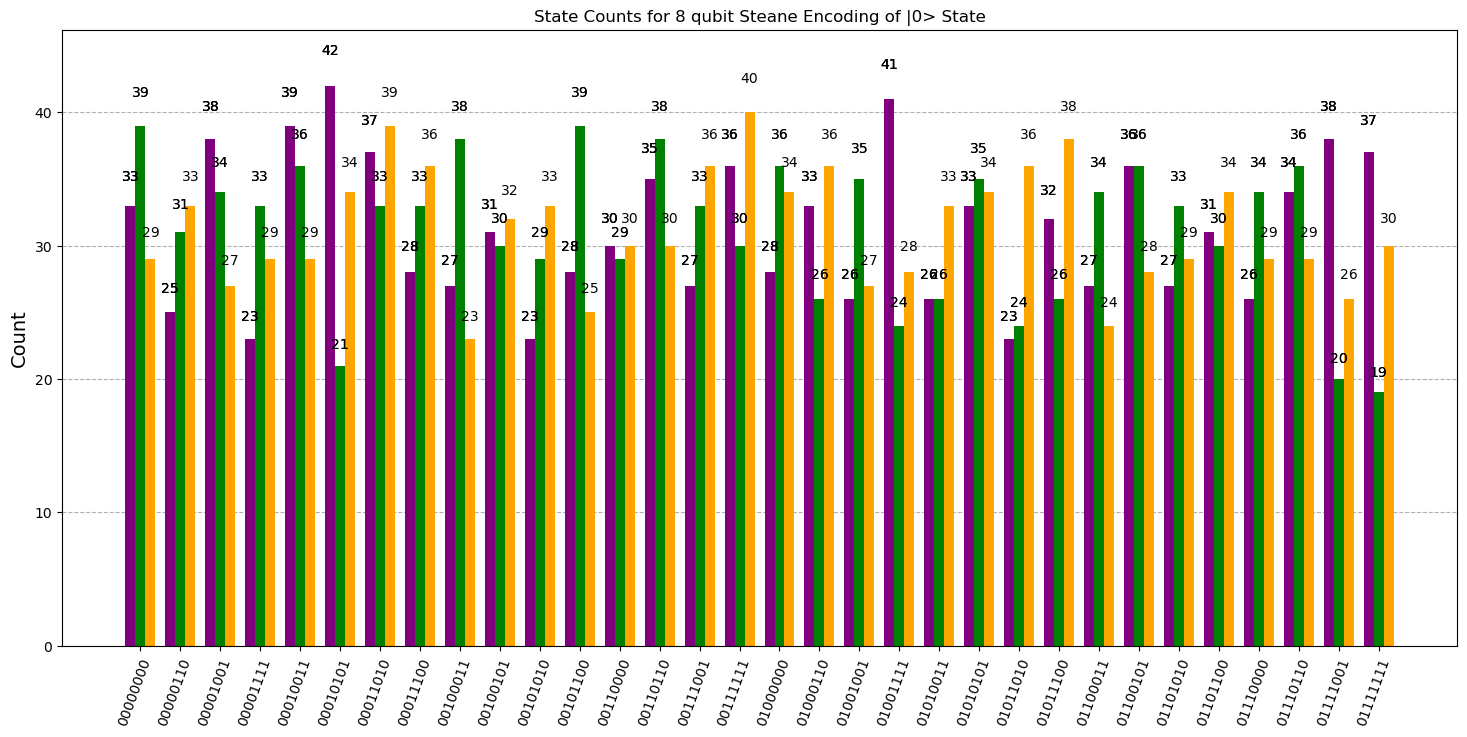

In [61]:
plot_histogram(counts_arr_meas[0:3], 
               figsize = (18, 8), 
               title = "State Counts for 8 qubit Steane Encoding of |0> State",
               color = ["purple", "green", "orange"])

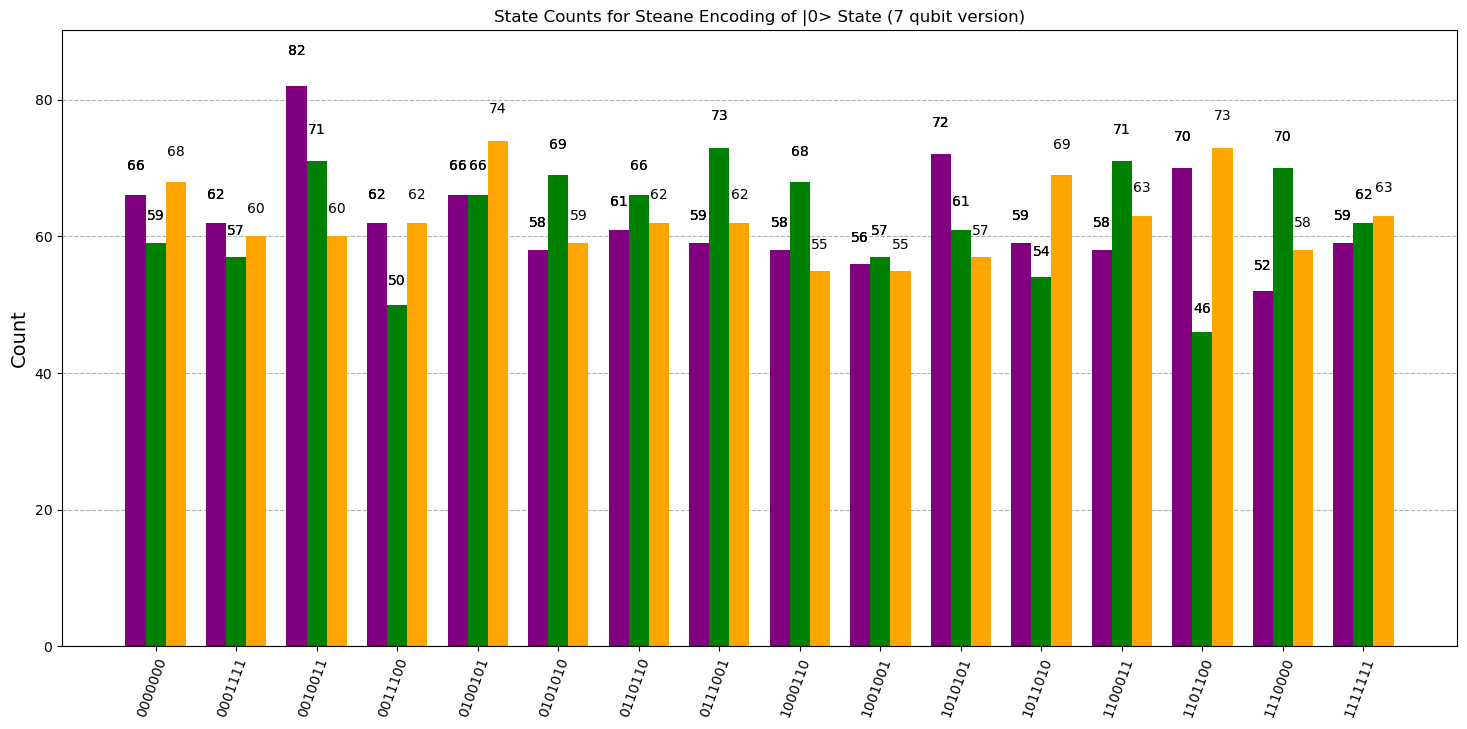

In [22]:
plot_histogram(counts_arr_meas_7[0:3], 
               figsize = (18, 8), 
               title = "State Counts for Steane Encoding of |0> State (7 qubit version)",
               color = ["purple", "green", "orange"])

In [23]:
def raw_v_enc(raw_sv: Statevector, state_arr_sv: list):
    fid_arr = []
    err_arr = []


    for z in state_arr_sv[0]:
        state = np.array([np.sqrt(1 - abs(z)**2), z], dtype=np.complex128)
        svi = Statevector(state)
        fid = state_fidelity(raw_sv, svi)
        #print(fid)
        err = 1 - fid
        fid_arr.append(fid)
        err_arr.append(err)



    mean_err = np.mean(err_arr)
    mean_fid = np.mean(fid_arr)


    return [err_arr, fid_arr, mean_err, mean_fid]


    
    

In [24]:

qc_arr_sv = []

[qc_arr_sv, state_arr_sv, counts_arr_sv] = preparation_results(qc_arr_sv, 8, True, False, steane_block_instr, no_noise)


qc_arr_7 = []


[qc_arr_7, state_arr_sv_7, counts_arr_sv_7] = preparation_results(qc_arr_7, 7, True, False, steane_block_instr_7, no_noise)




In [25]:
from qiskit.quantum_info import DensityMatrix

### Mean Error and Mean Fidelity of Ideal vs. Logical Steane Encoded |0>


In [26]:
# Compare ideal raw state to encoded state

# sv = Statevector([amp_0, amp_1])
# print(sv)
# print(state_arr_sv[0])

# [err_8_arr, fid_8_arr, err_8_mean, fid_8_mean] = raw_v_enc(sv, state_arr_sv)
# [err_7_arr, fid_7_arr, err_7_mean, fid_7_mean]  = raw_v_enc(sv, state_arr_sv_7)

# print(err_8_mean)
# print(err_7_mean)

In [27]:
import matplotlib.pyplot as plt

In [28]:

# plt.hist([err_8_arr, err_7_arr], bins = 20, color= ['green', 'blue'])
# plt.xlabel("Error")
# plt.ylabel("Counts")
# plt.title("Fidelity Errors Preparing |0> State in the Steane Code")

The mean error rate for 8 qubit encoding scheme is 0.39%, while the mean error rate for 7 qubit encoding is 0.78%

In [29]:
from qiskit.quantum_info import DensityMatrix


In [30]:
# 5% chance of flipping 0 <-> 1
readout_err = ReadoutError([[0.98, 0.02],  # P(measured 0 | actual 0), P(1 | 0)
                            [0.02, 0.98]]) # P(0 | 1), P(1 | 1)

noise_model = NoiseModel()

noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['id'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,2),['cz'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,2),['cx'])


# we actually don't want readout error because we want to measure the logical qubits that would be
# put into the 21 qubit MSD circuit w/o measuring
# for i in range(0,7):
#     noise_model.add_readout_error(readout_err, [i])

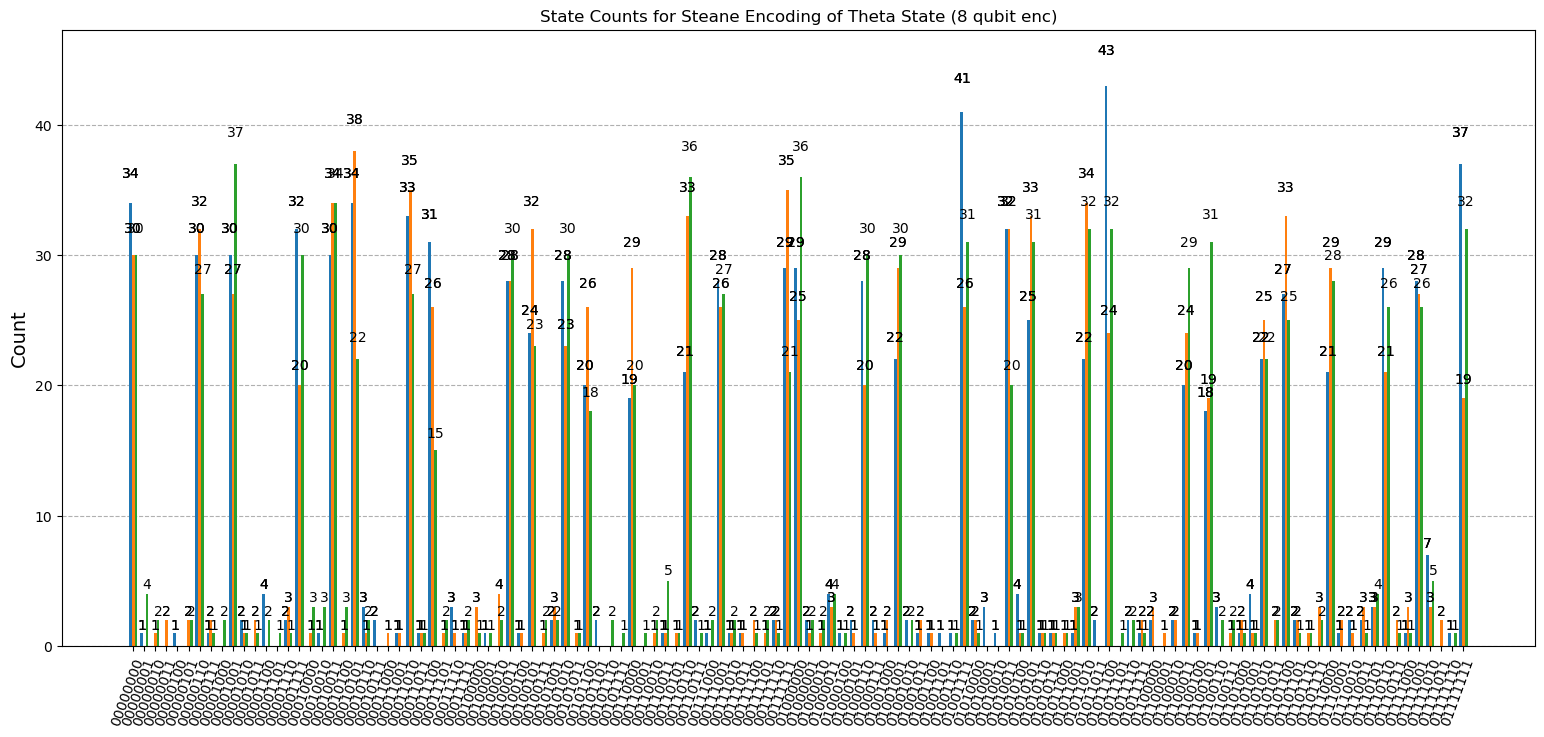

In [31]:


qc_arr_n = []

[qc_arr_n, state_arr_n, counts_arr_n] = preparation_results(qc_arr_n, 8, False, True, steane_block_instr_noise, noise_model)



plot_histogram(counts_arr_n[0:3], 
               figsize = (19, 8), 
               title = "State Counts for Steane Encoding of Theta State (8 qubit enc)")




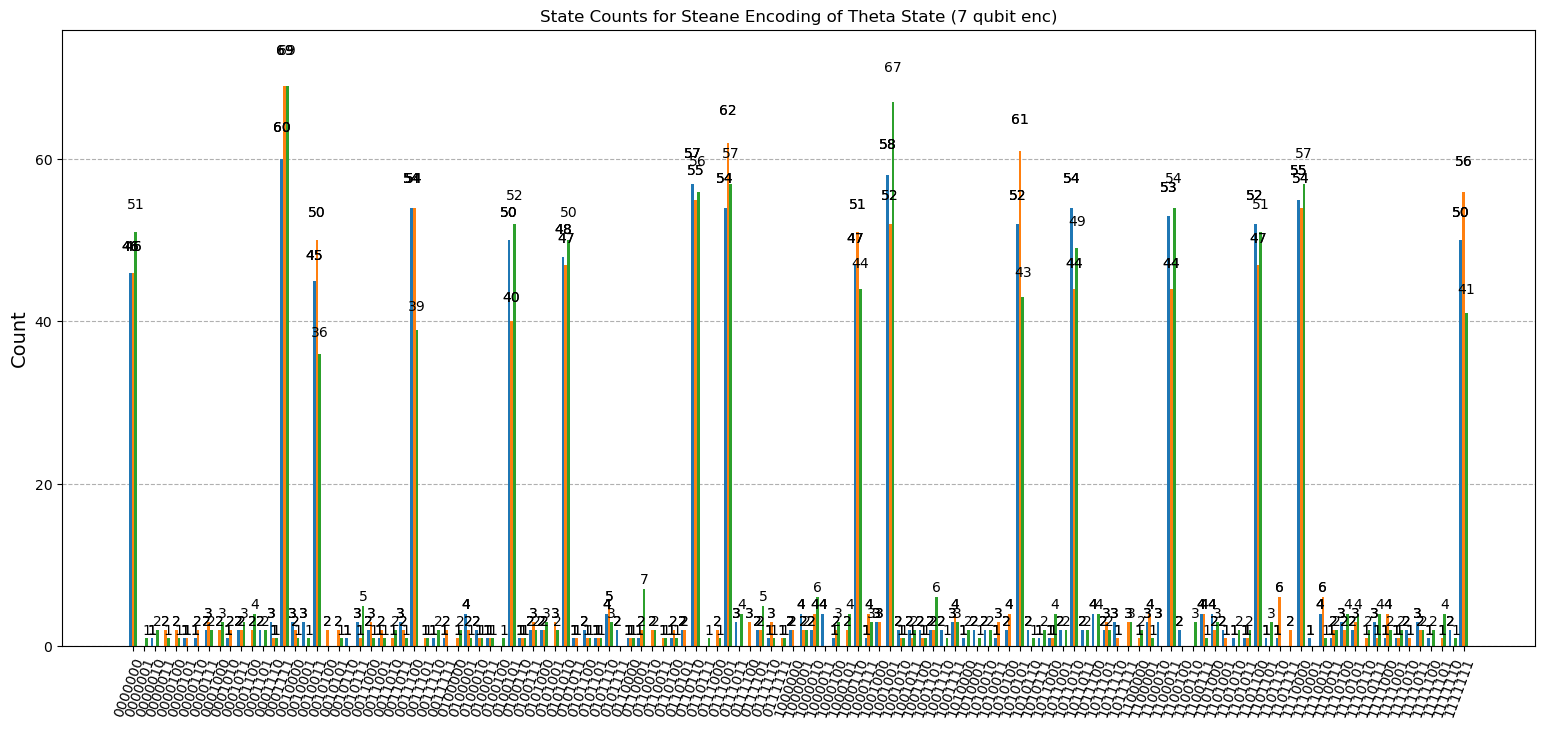

In [32]:


qc_arr_n_7 = []

[qc_arr_n_7, state_arr_n_7, counts_arr_n_7] = preparation_results(qc_arr_n_7, 7, False, True, steane_block_instr_7_noise, noise_model)


plot_histogram(counts_arr_n_7[0:3], 
               figsize = (19, 8), 
               title = "State Counts for Steane Encoding of Theta State (7 qubit enc)")

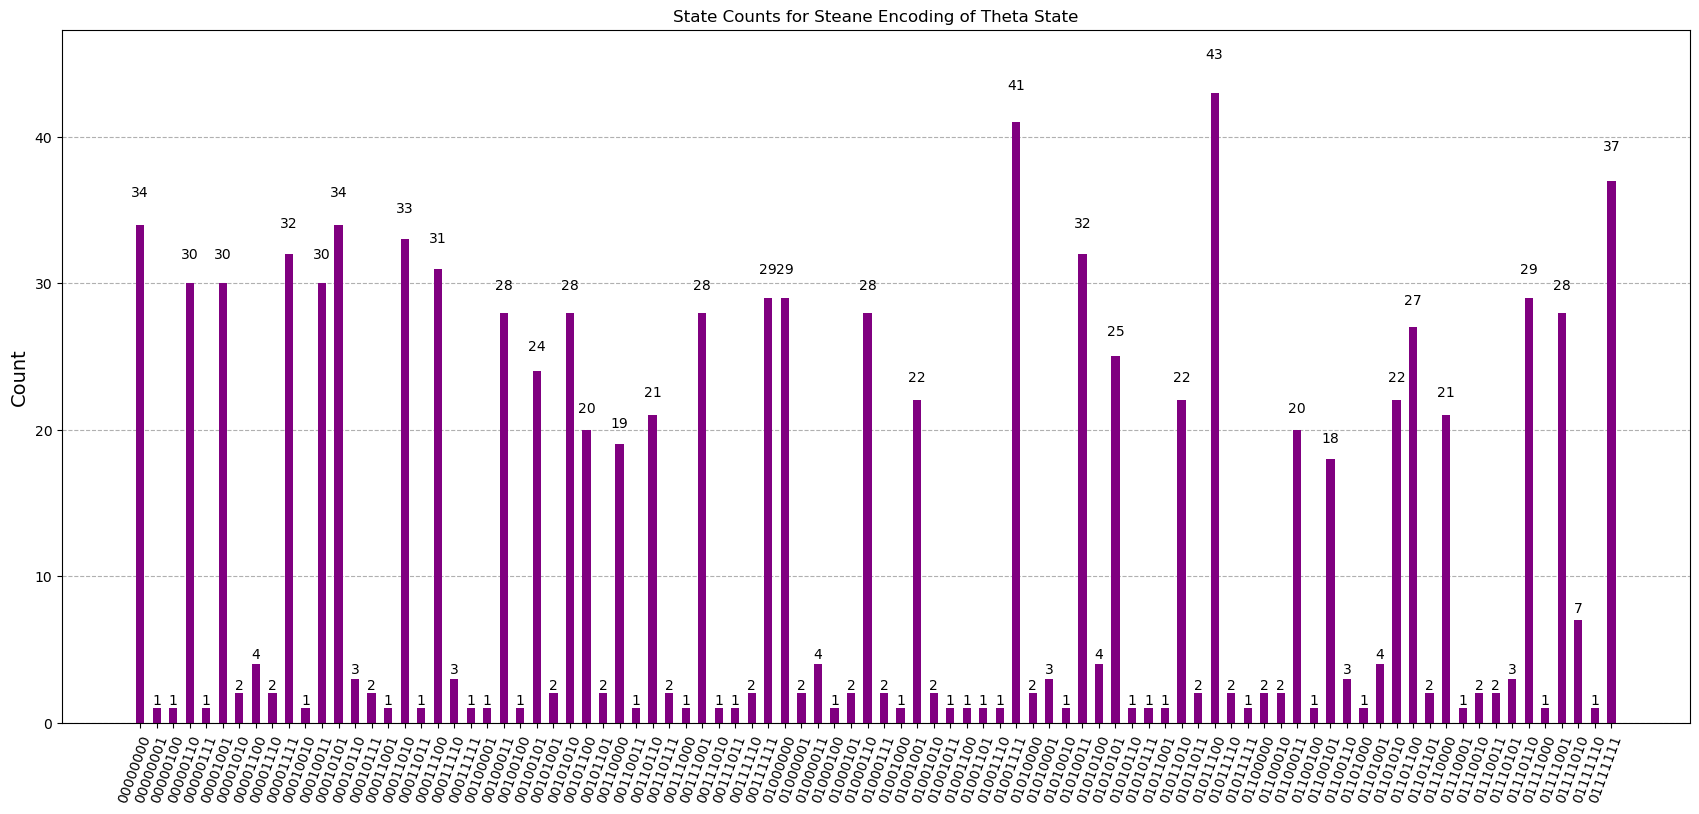

In [33]:
plot_histogram(counts_arr_n[0], 
               figsize = (21, 9), 
               title = "State Counts for Steane Encoding of Theta State",
               color = "purple")


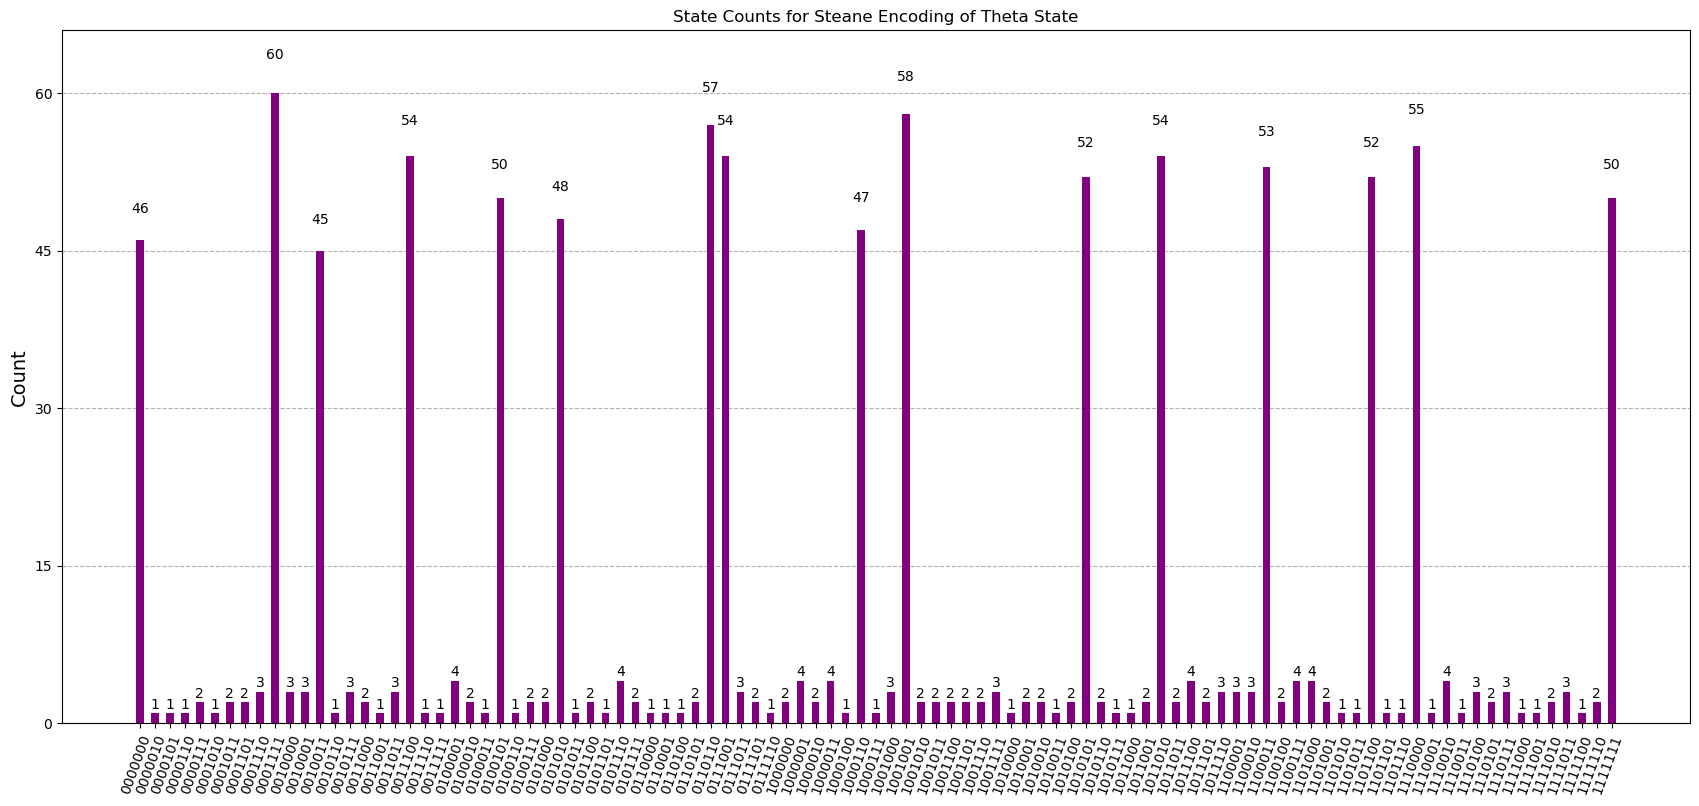

In [34]:
plot_histogram(counts_arr_n_7[0], 
               figsize = (21, 9), 
               title = "State Counts for Steane Encoding of Theta State",
               color = "purple")

## Fidelity of |0> by Statevector


KeyboardInterrupt: 

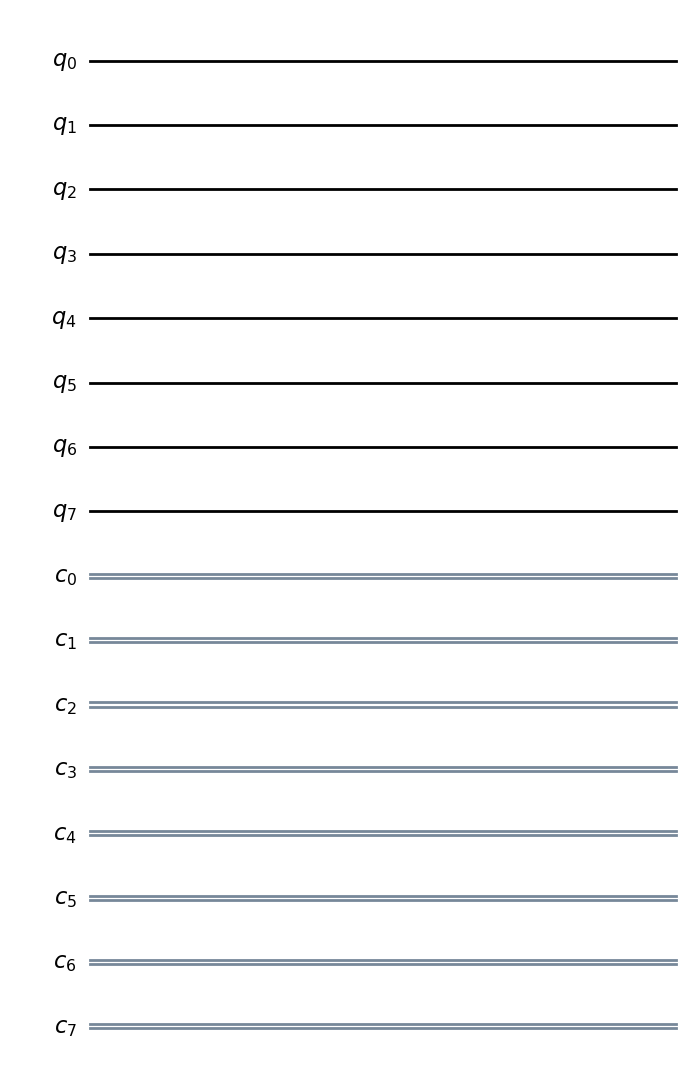

In [35]:
fid_7_arr_sv = []
fid_8_arr_sv = []

for i in range(0,100):
    qc_arr_7_ideal_sv = []
    qc_arr_7_n_sv = []
    qc_arr_8_ideal_sv = []
    qc_arr_8_n_sv = []

    [qc_arr_7_ideal_sv, state_arr_7_ideal_sv, counts_arr_7_ideal_sv] = preparation_results(qc_arr_7_ideal_sv, 
                                                                num = 7, 
                                                                is_ideal = True, 
                                                                is_counts = False, 
                                                                encoding = steane_block_instr_7, 
                                                                noise_model = no_noise)



    [qc_arr_7_n_sv, state_arr_7_n_sv, counts_arr_7_n_sv] = preparation_results(qc_arr_7_n_sv, 
                                                                    num = 7, 
                                                                    is_ideal = False, 
                                                                    is_counts = False, 
                                                                    encoding = steane_block_instr_7_noise, 
                                                                    noise_model = noise_model)
    
    
    

    [qc_arr_8_ideal_sv, state_arr_8_ideal_sv, counts_arr_8_ideal_sv] = preparation_results(qc_arr_8_ideal_sv, 
                                                                num = 8, 
                                                                is_ideal = True, 
                                                                is_counts = False, 
                                                                encoding = steane_block_instr, 
                                                                noise_model = no_noise)



    [qc_arr_8_n_sv, state_arr_8_n_sv, counts_arr_8_n_sv] = preparation_results(qc_arr_8_n_sv, 
                                                                    num = 8, 
                                                                    is_ideal = False, 
                                                                    is_counts = False, 
                                                                    encoding = steane_block_instr_noise, 
                                                                    noise_model = noise_model)



    
    for i in range(0,3):
        sv_7_ideal = Statevector(state_arr_7_ideal_sv[i])
        sv_7_noise = Statevector(state_arr_7_n_sv[i])
        sv_8_ideal = Statevector(state_arr_8_ideal_sv[i])
        sv_8_noise = Statevector(state_arr_8_n_sv[i])
        fid_7 = state_fidelity(sv_7_ideal, sv_7_noise)
        fid_8 = state_fidelity(sv_8_ideal, sv_8_noise)
        fid_7_arr_sv.append(fid_7)
        fid_8_arr_sv.append(fid_8)

print(fid_7_arr_sv)
print(np.mean(fid_7_arr_sv))
print(fid_8_arr_sv)
print(np.mean(fid_8_arr_sv))


In [36]:
from collections import defaultdict
import numpy as np

def fidelity_from_counts(counts_ideal, counts_noisy):
    # Normalize to probabilities
    total_ideal = sum(counts_ideal.values())
    total_noisy = sum(counts_noisy.values())

    p = defaultdict(float, {k: v / total_ideal for k, v in counts_ideal.items()})
    q = defaultdict(float, {k: v / total_noisy for k, v in counts_noisy.items()})

    # Get all keys
    all_keys = set(p) | set(q)

    # Bhattacharyya coefficient
    bc = sum(np.sqrt(p[k] * q[k]) for k in all_keys)
    return bc ** 2  # fidelity minimum bound

## Fidelity of |0> by counts

In [ ]:

mean_arr_fid = []
for i in range(0,3):
    ffc = fidelity_from_counts(counts_arr_meas[i], counts_arr_n[i])
    mean_arr_fid.append(ffc)


print(mean_arr_fid)
print(np.mean(mean_arr_fid))



[0.8773389639694423, 0.9016423959635895, 0.8958888699094852]
0.8916234099475057


In [ ]:
mean_arr_fid_7 = []
for i in range(0,3):
    ffc = fidelity_from_counts(counts_arr_meas_7[i], counts_arr_n_7[i])
    mean_arr_fid_7.append(ffc)


print(mean_arr_fid_7)
print(np.mean(mean_arr_fid_7))


[0.8391074528649658, 0.8094258836376473, 0.8031842568086991]
0.8172391977704375


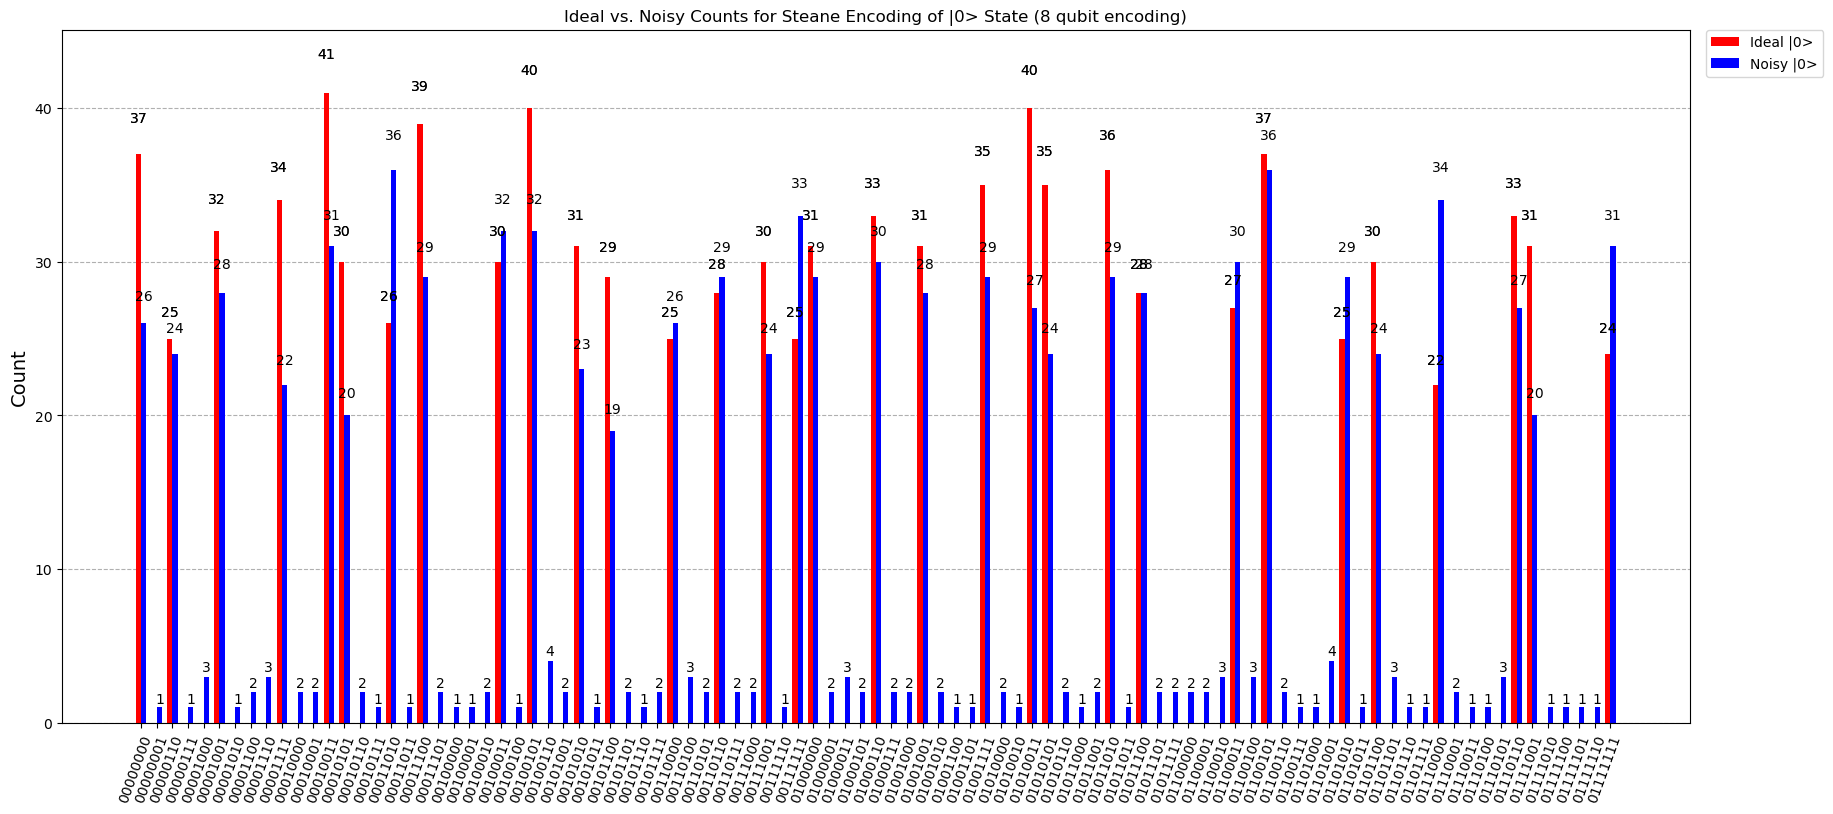

In [ ]:
plot_histogram([counts_arr_meas[0], counts_arr_n[0]], 
               figsize = (21, 9), 
               title = "Ideal vs. Noisy Counts for Steane Encoding of |0> State (8 qubit encoding)", 
               bar_labels = True, 
               legend=['Ideal |0>', 'Noisy |0>'],
               color = ["red", "blue"])

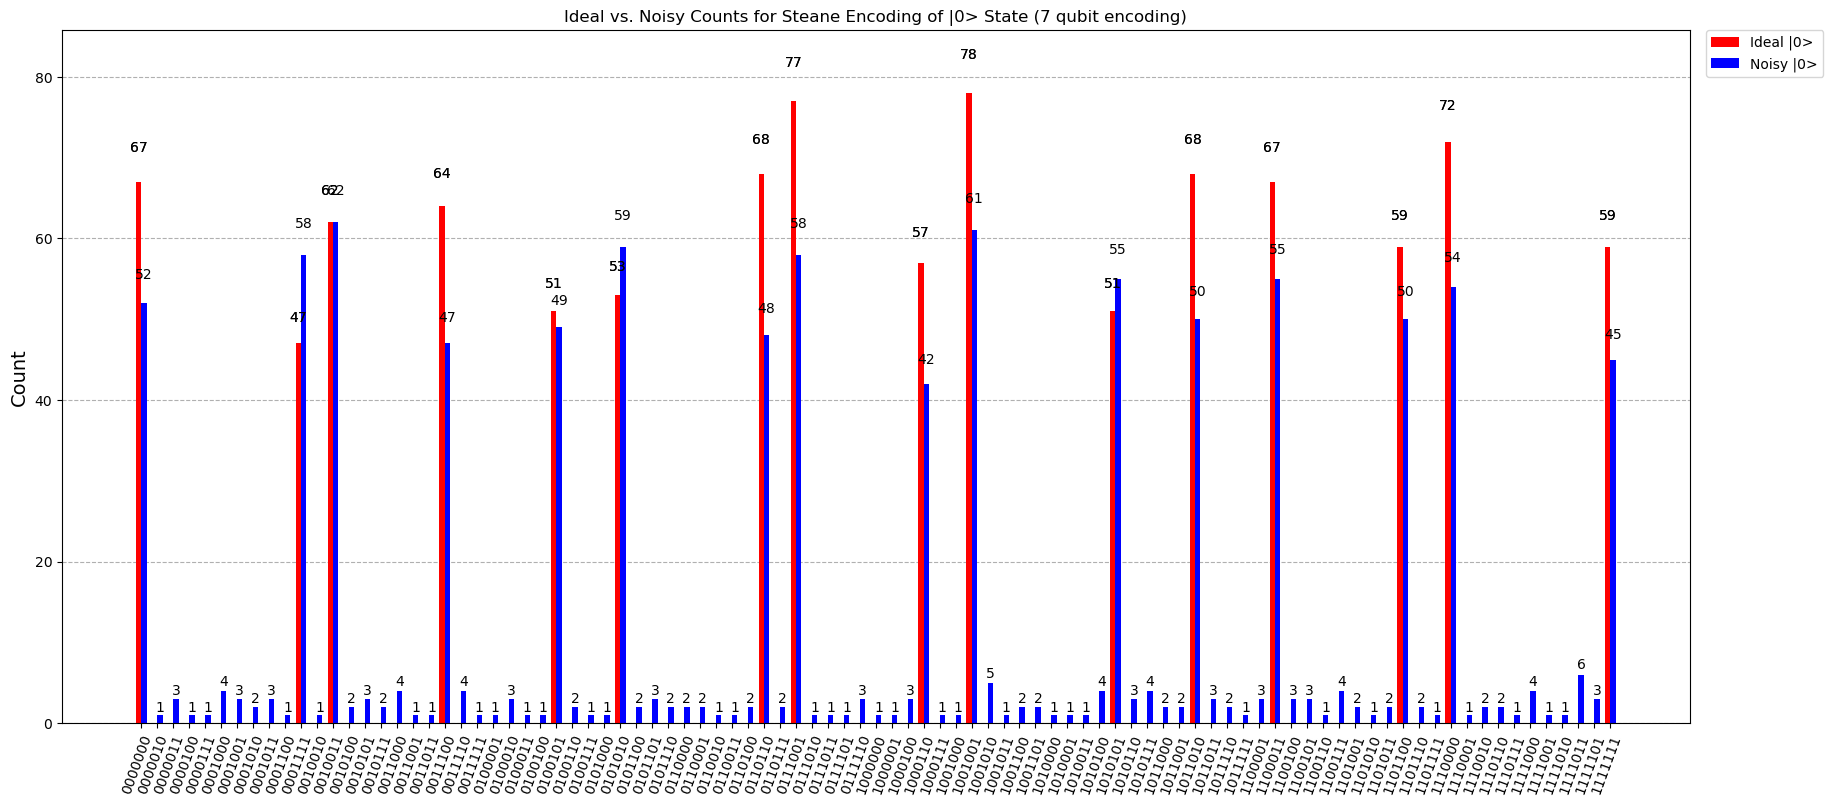

In [ ]:
plot_histogram([counts_arr_meas_7[0], counts_arr_n_7[0]], 
               figsize = (21, 9), 
               title = "Ideal vs. Noisy Counts for Steane Encoding of |0> State (7 qubit encoding)", 
               bar_labels = True, 
               legend=['Ideal |0>', 'Noisy |0>'],
               color = ["red", "blue"])

# Testing Theta state

Now we test the theta state! We should obtain a similar fidelity

In [44]:

theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0_theta = np.cos(theta/2)
amp_1_theta = np.sin(theta/2)

print(Statevector([amp_0_theta, amp_1_theta]))

steane_intr_theta_ideal = steane_enc_8(amp_0_theta, amp_1_theta, True).to_instruction()
steane_intr_theta_ideal_7 = steane_enc_7(amp_0_theta, amp_1_theta, True).to_instruction()

Statevector([0.94502682+0.j, 0.32699283+0.j],
            dims=(2,))


In [45]:
steane_intr_theta_n = steane_enc_8(amp_0_theta, amp_1_theta, False).to_instruction()
steane_intr_theta_n_7 = steane_enc_7(amp_0_theta, amp_1_theta, False).to_instruction()

In [46]:
type(steane_intr_theta_n )

qiskit.circuit.instruction.Instruction

In [47]:
print(steane_intr_theta_n)

Instruction(name='steane_block_noise', num_qubits=8, num_clbits=0, params=[])


In [ ]:

qc_arr_theta_n = []


[qc_arr_theta_n, 
 state_arr_theta_n, 
 counts_arr_theta_n] = preparation_results(qc_arr_theta_n, 
                                                num = 8, 
                                                is_ideal=False, 
                                                is_counts=True, 
                                                encoding=steane_intr_theta_n, 
                                                noise_model=noise_model)

qc_arr_n_theta_7 = []

[qc_arr_n_theta_7, 
 state_arr_theta_n_7, 
 counts_arr_theta_n_7] = preparation_results(qc_arr_n_theta_7, 
                                             num = 7, 
                                             is_ideal=False, 
                                             is_counts=True, 
                                             encoding=steane_intr_theta_n_7, 
                                             noise_model=noise_model)

    



In [ ]:

qc_arr_theta = []

[qc_arr_theta, 
 state_arr_theta_ideal, 
 counts_arr_theta_ideal] = preparation_results(qc_arr_theta, 
                                               num=8, 
                                               is_ideal=True, 
                                               is_counts=True, 
                                               encoding= steane_block_instr, 
                                               noise_model=no_noise)

qc_arr_theta_7 = []

[qc_arr_theta_7, 
 state_arr_theta_ideal_7, 
 counts_arr_theta_ideal_7] = preparation_results(qc_arr_n_7, 
                                                 num=7, 
                                                 is_ideal=True, 
                                                 is_counts=True, 
                                                 encoding=steane_block_instr_7, 
                                                 noise_model=no_noise)

In [ ]:
# sv_theta = Statevector([amp_0_theta, amp_1_theta])
# print(sv_theta)
# print(state_arr_theta_sv)

# [err_8_arr, fid_8_arr, err_8_mean, fid_8_mean] = raw_v_enc(sv_theta, state_arr_theta_sv)
# [err_7_arr, fid_7_arr, err_7_mean, fid_7_mean]  = raw_v_enc(sv_theta, state_arr_theta_sv_7)

# print(err_8_mean)
# print(err_7_mean)

## Ideal Plots

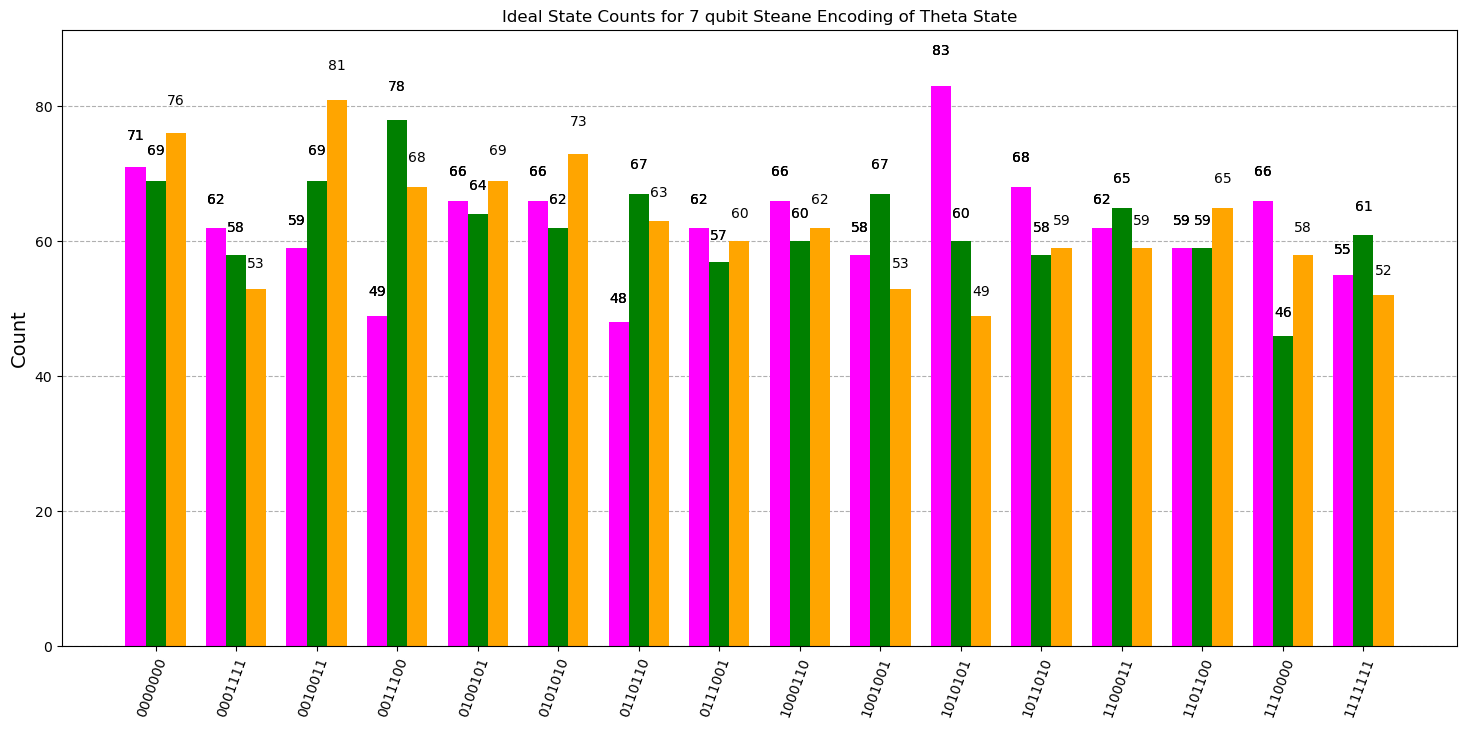

In [ ]:
plot_histogram(counts_arr_theta_ideal_7[0:3], 
               figsize = (18, 8), 
               title = "Ideal State Counts for 7 qubit Steane Encoding of Theta State",
               color = ["magenta", "green", "orange"])

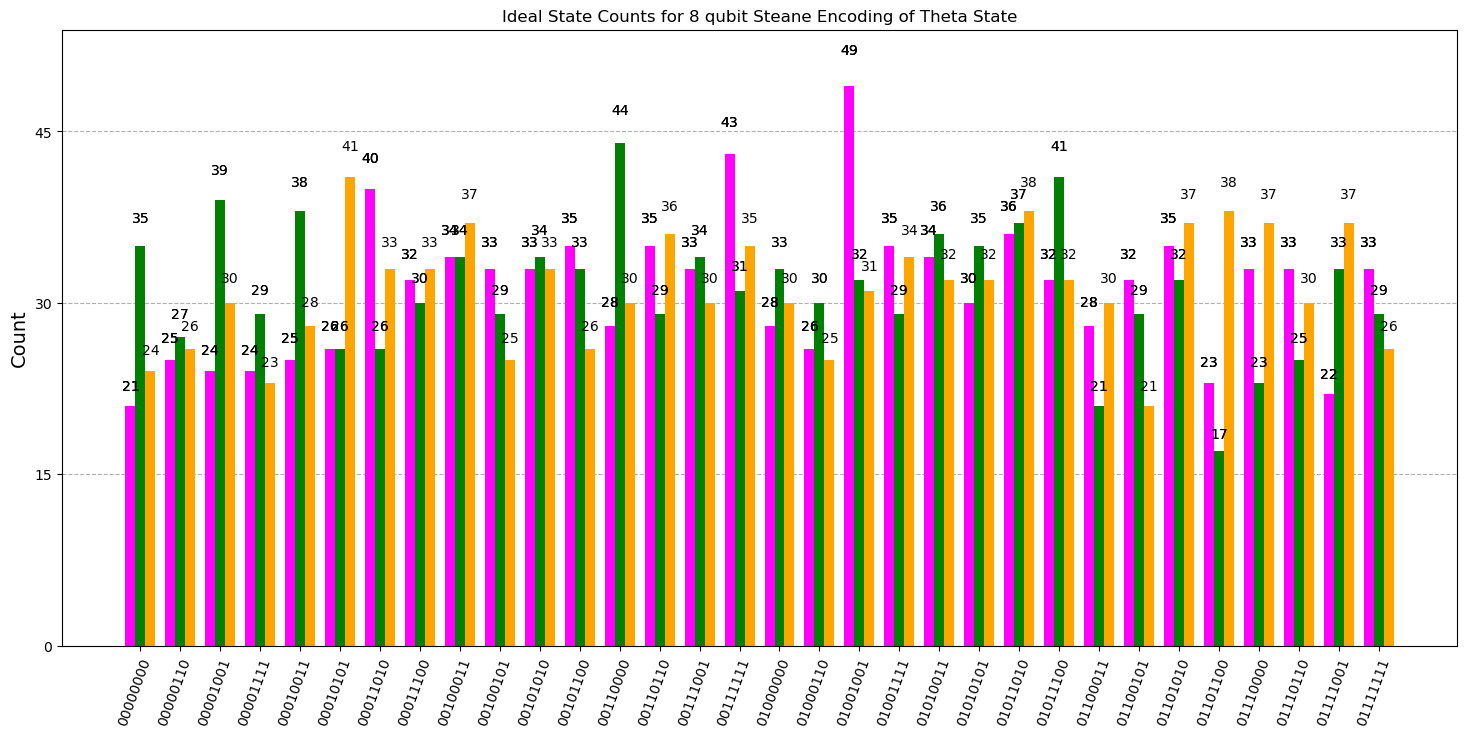

In [ ]:
plot_histogram(counts_arr_theta_ideal[0:3], 
               figsize = (18, 8), 
               title = "Ideal State Counts for 8 qubit Steane Encoding of Theta State",
               color = ["magenta", "green", "orange"])

## Noisy plots

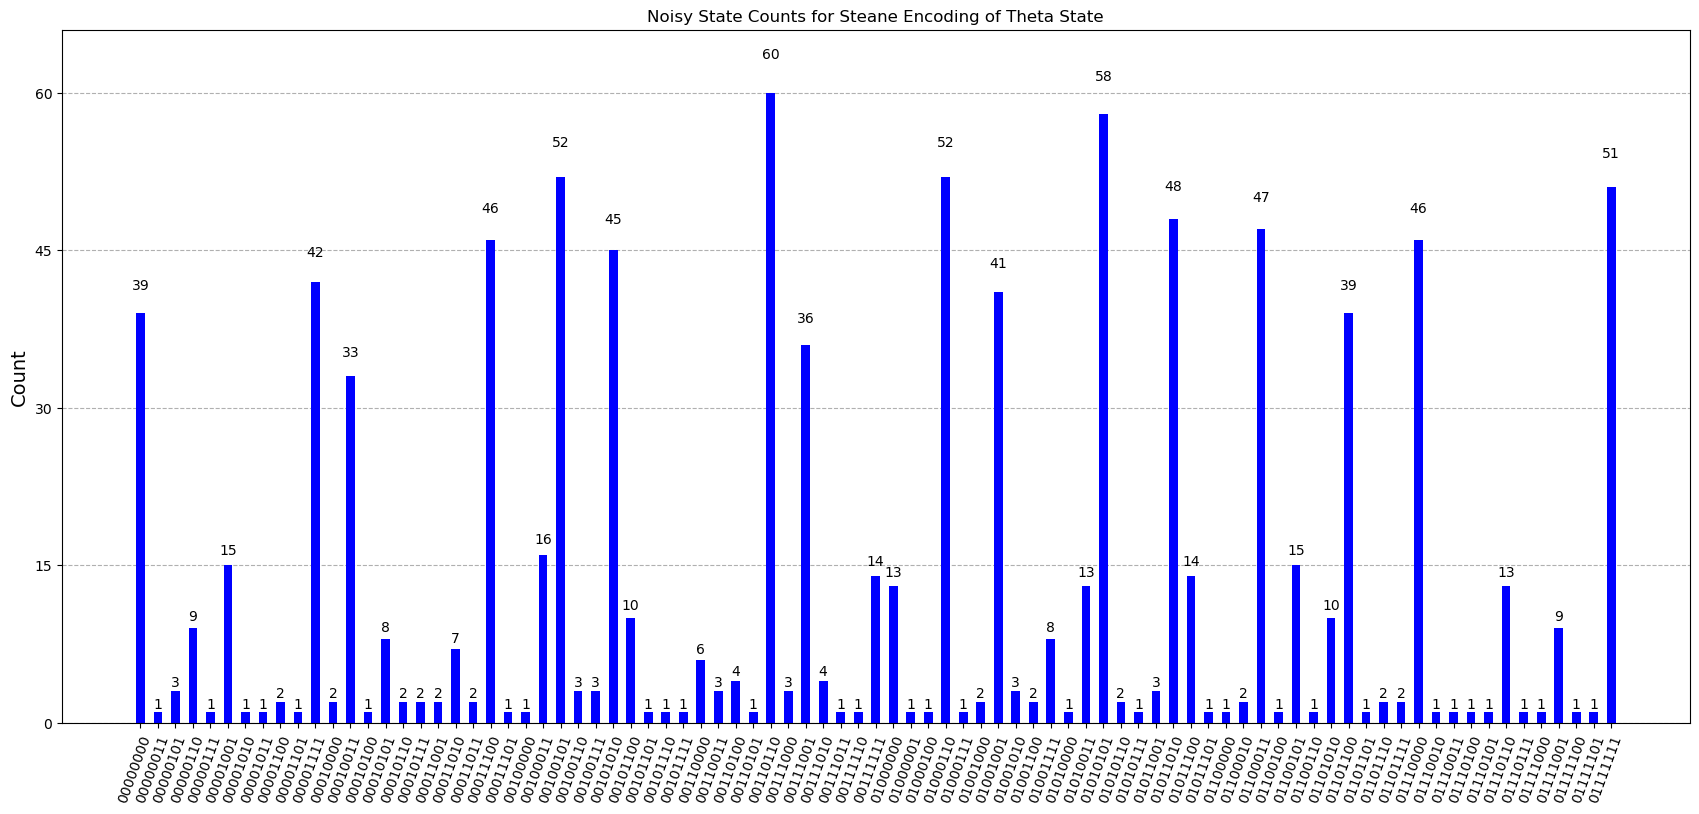

In [ ]:
plot_histogram(counts_arr_theta_n[0], 
               figsize = (21, 9), 
               title = "Noisy State Counts for Steane Encoding of Theta State", 
               bar_labels = True,
               color = "blue")

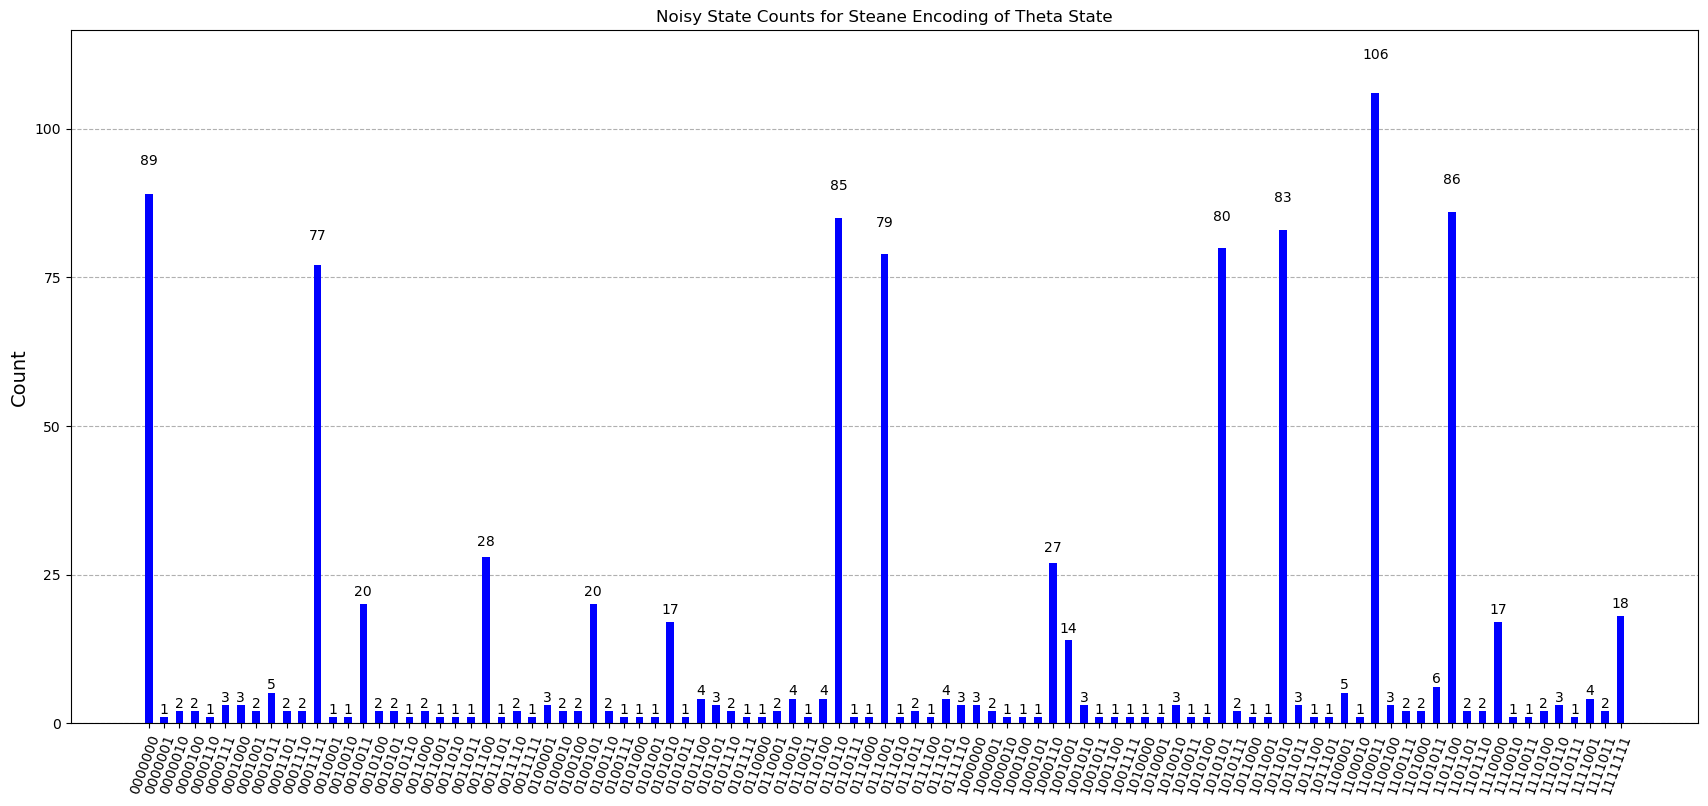

In [ ]:
plot_histogram(counts_arr_theta_n_7[0], 
               figsize = (21, 9), 
               title = "Noisy State Counts for Steane Encoding of Theta State", 
               bar_labels = True,
               color = "blue")

# Fidelity of |theta> by Statevector

Apologies for the hideous nested for-loop, I'm not yet quite sure how to alter my code to prevent this.

In [ ]:
fid_theta_7_arr_sv = []
fid_theta_8_arr_sv = []

for i in range(0,100):
    qc_arr_theta_7_ideal_sv = []
    qc_arr_theta_7_n_sv = []
    qc_arr_theta_8_ideal_sv = []
    qc_arr_theta_8_n_sv = []

    [qc_arr_theta_7_ideal_sv, 
     state_arr_theta_7_ideal_sv, 
     counts_arr_theta_7_ideal_sv] = preparation_results(qc_arr_theta_7_ideal_sv, 
                                                                num = 7, 
                                                                is_ideal = True, 
                                                                is_counts = False, 
                                                                encoding = steane_intr_theta_ideal_7, 
                                                                noise_model = no_noise)



    [qc_arr_theta_7_n_sv, 
     state_arr_theta_7_n_sv, 
     counts_arr_theta_7_n_sv] = preparation_results(qc_arr_theta_7_n_sv, 
                                                                    num = 7, 
                                                                    is_ideal = False, 
                                                                    is_counts = False, 
                                                                    encoding = steane_intr_theta_n_7, 
                                                                    noise_model = noise_model)
    
    
    

    [qc_arr_theta_8_ideal_sv, 
     state_arr_theta_8_ideal_sv, 
     counts_arr_theta_8_ideal_sv] = preparation_results(qc_arr_theta_8_ideal_sv, 
                                                                num = 8, 
                                                                is_ideal = True, 
                                                                is_counts = False, 
                                                                encoding = steane_intr_theta_ideal, 
                                                                noise_model = no_noise)



    [qc_arr_theta_8_n_sv, 
     state_arr_theta_8_n_sv, 
     counts_arr_theta_8_n_sv] = preparation_results(qc_arr_theta_8_n_sv, 
                                                                    num = 8, 
                                                                    is_ideal = False, 
                                                                    is_counts = False, 
                                                                    encoding = steane_intr_theta_n, 
                                                                    noise_model = noise_model)



    
    for j in range(0,3):
        sv_theta_7_ideal = Statevector(state_arr_theta_7_ideal_sv[j])
        sv_theta_7_noise = Statevector(state_arr_theta_7_n_sv[j])
        sv_theta_8_ideal = Statevector(state_arr_theta_8_ideal_sv[j])
        sv_theta_8_noise = Statevector(state_arr_theta_8_n_sv[j])
        fid_7 = state_fidelity(sv_theta_7_ideal, sv_theta_7_noise)
        fid_8 = state_fidelity(sv_theta_8_ideal, sv_theta_8_noise)
        fid_theta_7_arr_sv.append(fid_7)
        fid_theta_8_arr_sv.append(fid_8)

#print(fid_7_arr_sv)
print(np.mean(fid_theta_7_arr_sv))
#print(fid_8_arr_sv)
print(np.mean(fid_theta_8_arr_sv))


c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


0.7720601132958342
0.8487267799624998


In [ ]:
Statevector(state_arr_theta_7_ideal_sv[2])

Statevector([ 3.18004912e-01+1.36305294e-16j,
              2.62217765e-33-1.94721849e-17j,
              3.30701542e-33-1.94721849e-17j,
             -5.80519067e-35-9.46091683e-18j,
              1.99639872e-33-1.94721849e-17j,
             -2.16338357e-18-9.46091683e-18j,
              5.47926615e-18-9.46091683e-18j,
             -1.16743961e-17-1.94721849e-17j,
             -1.16743961e-17-1.94721849e-17j,
              5.47926615e-18-9.46091683e-18j,
             -2.16338357e-18-9.46091683e-18j,
              1.99639872e-33-1.94721849e-17j,
             -5.80519067e-35-9.46091683e-18j,
              3.30701542e-33-1.94721849e-17j,
              2.62217765e-33-1.94721849e-17j,
              3.18004912e-01+1.36305294e-16j,
              1.87116224e-33-1.94721849e-17j,
             -1.66849556e-33-9.46091683e-18j,
             -3.09219013e-33-9.46091683e-18j,
              1.54508497e-01+6.62264178e-17j,
             -7.06992250e-18-9.46091683e-18j,
              7.03685749e-18-1.947

In [ ]:
fid_theta_7_arr_sv

[1.0000000000000013,
 1.0000000000000013,
 1.0000000000000013,
 1.0000000000000013,
 4.149848861553851e-36,
 1.0000000000000013,
 1.0000000000000013,
 1.0000000000000013,
 1.49975978266186e-32,
 1.0000000000000013,
 1.0000000000000013,
 1.0000000000000013,
 1.645901843446476e-96,
 1.0000000000000013,
 1.0000000000000013,
 1.0000000000000013,
 1.0000000000000013,
 2.7653840785701906e-66,
 1.0000000000000013,
 1.0000000000000013,
 4.040610940368063e-66,
 2.294545452594907e-66,
 1.0000000000000013,
 1.0000000000000013,
 1.0000000000000013,
 1.0000000000000013,
 5.728572620166756e-33,
 1.0000000000000013,
 1.556321698659186e-67,
 1.0000000000000013,
 1.0000000000000013,
 1.0000000000000013,
 1.0000000000000013,
 1.49975978266186e-32,
 1.0000000000000013,
 1.0000000000000013,
 1.0000000000000013,
 1.0000000000000013,
 1.0000000000000013,
 1.0000000000000013,
 1.0000000000000013,
 1.0000000000000013,
 1.0000000000000013,
 2.373891936439975e-66,
 1.0000000000000013,
 1.0000000000000013,
 1.00

Text(0.5, 1.0, 'Fidelity Preparing |theta> State in the Steane Code')

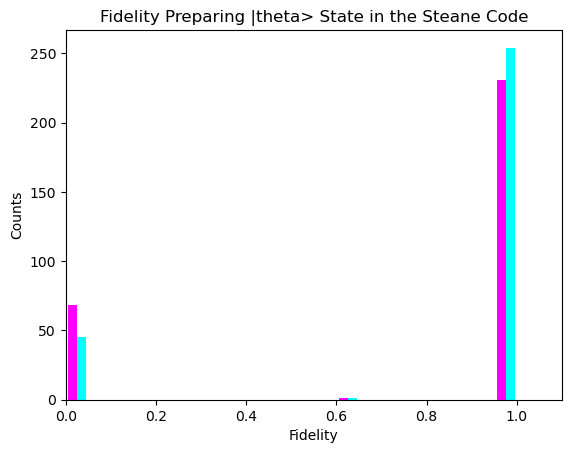

In [ ]:
plt.hist([fid_theta_7_arr_sv, fid_theta_8_arr_sv], bins = 20, color= ['magenta', 'cyan'])
plt.xlim(0,1.1)
plt.xlabel("Fidelity")
plt.ylabel("Counts")
plt.title("Fidelity Preparing |theta> State in the Steane Code")

In [ ]:
# plt.hist([err_8_arr, err_7_arr], bins = 20, color= ['green', 'blue'])
# plt.xlim(0,0.9)
# plt.xlabel("Error")
# plt.ylabel("Counts")
# plt.title("Fidelity Errors Preparing |theta> State in the Steane Code")

# Fidelity of |theta> by Counts

In [ ]:
mean_arr_theta_fid = []
err_arr_theta = []
for i in range(0,3):
    ffc = fidelity_from_counts(counts_arr_theta_ideal[i], counts_arr_theta_n[i])
    mean_arr_theta_fid.append(ffc)
    err_arr_theta.append(1 - ffc)



print(mean_arr_theta_fid)
print(np.mean(mean_arr_theta_fid))

[0.8043534122816351, 0.7591195784982585, 0.7619134771725042]
0.7751288226507992


In [ ]:
mean_arr_theta_fid = []
err_arr_theta = []
for i in range(0,3):
    ffc = fidelity_from_counts(counts_arr_theta_ideal_7[i], counts_arr_theta_n_7[i])
    mean_arr_theta_fid.append(ffc)
    err_arr_theta.append(1 - ffc)



print(mean_arr_theta_fid)
print(np.mean(mean_arr_theta_fid))

[0.7324668966061657, 0.7346092442873863, 0.7160568291477115]
0.7277109900137545


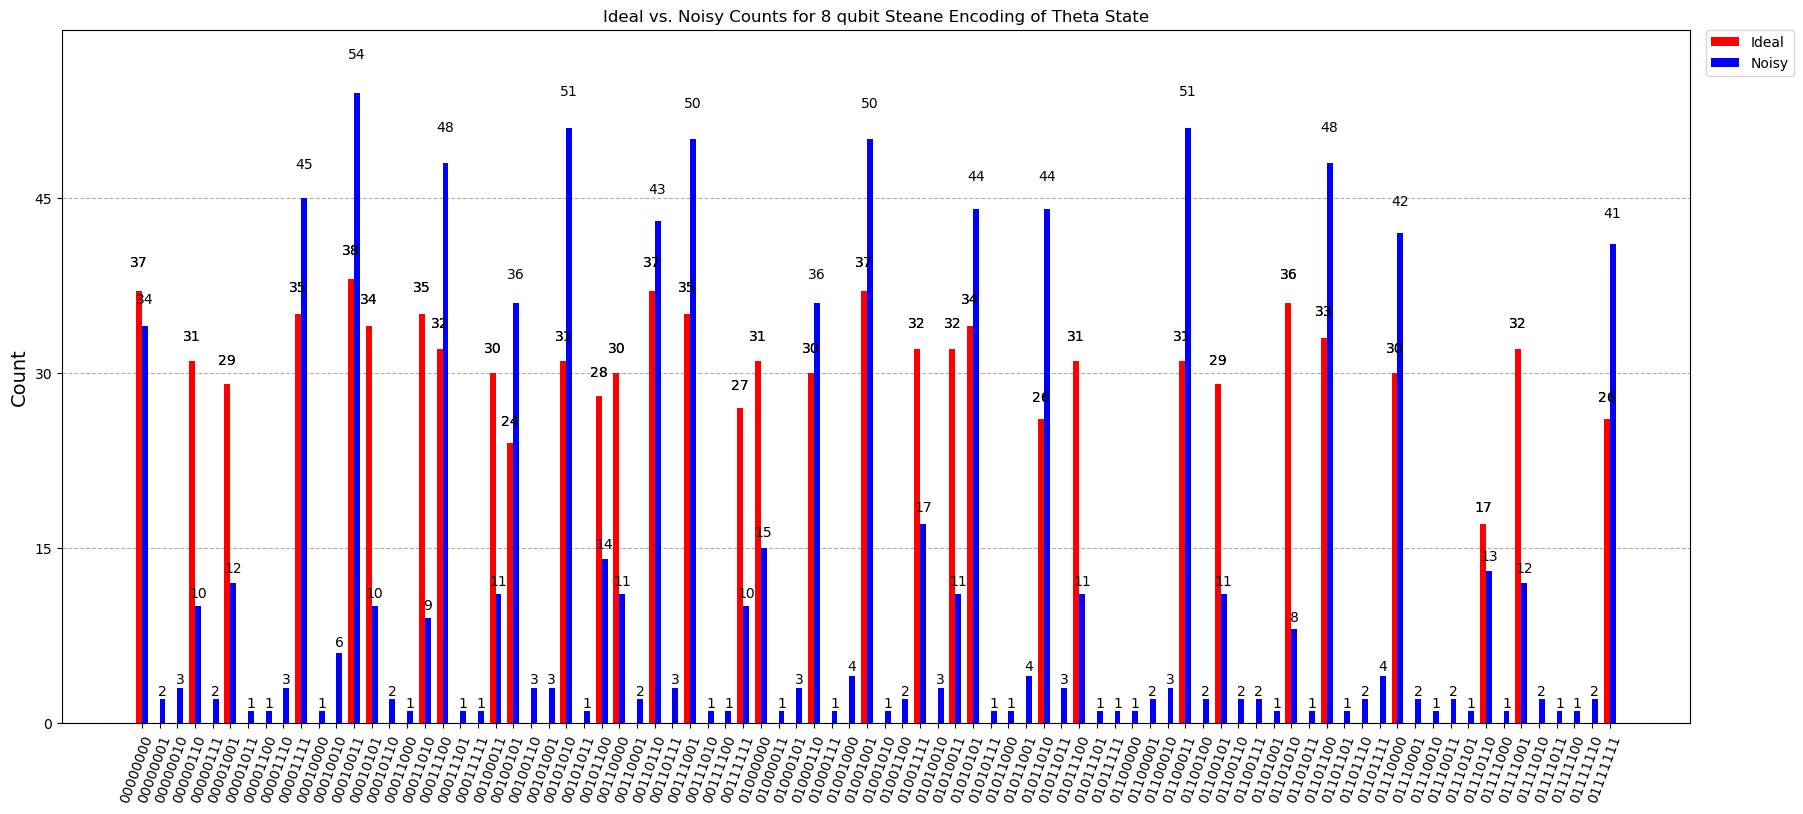

In [ ]:
plot_histogram([counts_arr_theta_ideal[0], counts_arr_theta_n[0]], 
               figsize = (21, 9), 
               title = "Ideal vs. Noisy Counts for 8 qubit Steane Encoding of Theta State", 
               bar_labels = True, 
               legend=['Ideal', 'Noisy'],
               color = ["red", "blue"])



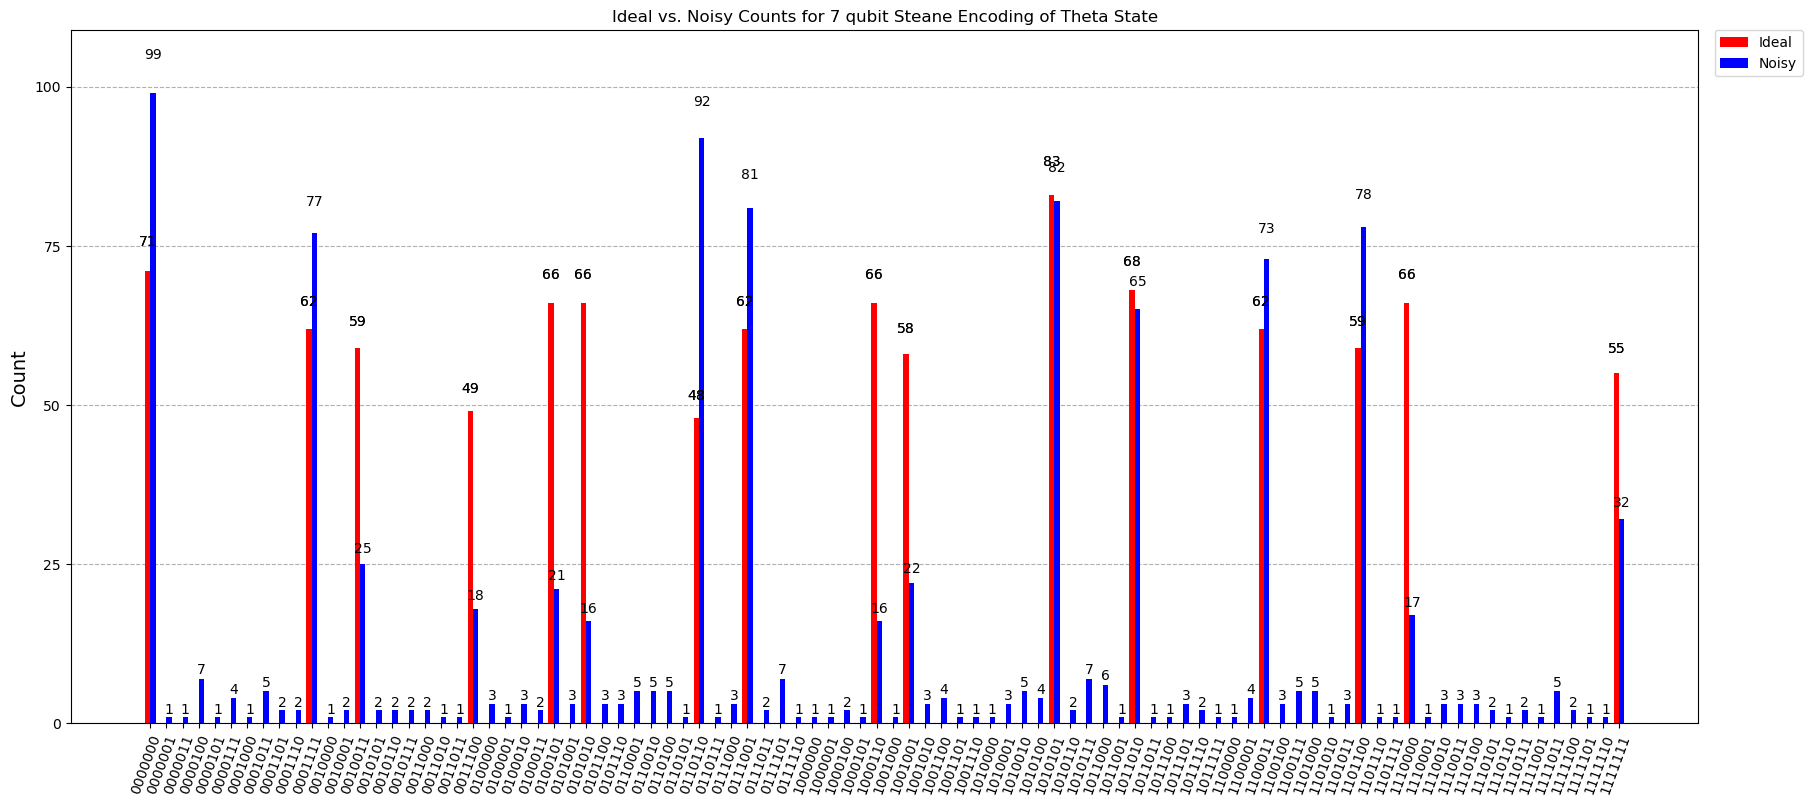

In [ ]:
plot_histogram([counts_arr_theta_ideal_7[0], counts_arr_theta_n_7[0]], 
               figsize = (21, 9), 
               title = "Ideal vs. Noisy Counts for 7 qubit Steane Encoding of Theta State", 
               bar_labels = True, 
               legend=['Ideal', 'Noisy'],
               color = ["red", "blue"])

# Logical vs Physical error rates


In [41]:
import pandas as pd

In [125]:

def preparation_results_2(num: int, is_ideal: bool, is_counts:bool, encoding: Instruction, noise_model: NoiseModel, shots = 1000):


    qc = QuantumCircuit(num,num)

    state = []
    counts = []

  
    prepare_state(qc, encoding, create_id_block(num, is_ideal), num, is_ideal)

    if (is_counts == True):
        for j in range(0,7):
            qc.measure(j,j)


    if is_counts == False:
        if is_ideal == True:
            simulator = Aer.get_backend('statevector_simulator')
            steane_t = transpile(qc, simulator)
            job = simulator.run(steane_t, shots=shots)
            result = job.result()
            # counts = result.get_counts()
            state = result.get_statevector()
            
            # counts_arr.append(counts)
        else:
            # for j in range(0,7):
            #     qc_arr[i].measure(j,j)
            qc.save_statevector(label='state_post', pershot=True, conditional=True)
            backend = AerSimulator(noise_model=noise_model)
            transpiled = transpile(qc, backend)
            job = backend.run(transpiled, shots=shots)
            result = job.result()
            # state = result.get_statevector()
            # state_arr.append(state)
            state = result.data()['state_post']
            print(state)
            for shot in state['0x0']:
                state = shot.data
                print(state)
    else:
        backend = AerSimulator(noise_model=noise_model)
        transpiled = transpile(qc, backend)
        job = backend.run(transpiled, shots=shots)
        result = job.result()
        counts = result.get_counts()
        

    return [qc, state, counts]

In [122]:
steane_intr_theta_ideal_7

Instruction(name='steane_block', num_qubits=7, num_clbits=7, params=[])

In [ ]:
[qc_theta_7_noise_sv, 
     state_theta_7_noise_sv, 
     counts_theta_7_noise_sv] = preparation_results_2(num = 7, 
                                                    is_ideal = False, 
                                                    is_counts = False, 
                                                    encoding = steane_intr_theta_n_7, 
                                                    noise_model = noise_model,
                                                    shots = 100000)

In [64]:

err_list_size = 15
error_list = np.logspace(-3,-2, err_list_size)
noise_list = []

for error in error_list:
    readout_err = ReadoutError([[0.98, 0.02],  # P(measured 0 | actual 0), P(1 | 0)
                                [0.02, 0.98]]) # P(0 | 1), P(1 | 1)

    noise_model = NoiseModel()

    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,2),['cz'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,2),['cx'])
    
    noise_list.append(noise_model)



In [65]:
fid_theta_7_sv_df = pd.DataFrame(columns= error_list)
fid_theta_8_sv_df = pd.DataFrame(columns= error_list)

fid_theta_7_sv_list = []
fid_theta_8_sv_list = []

# fid_theta_7_sv_series = pd.Series(dtype=float)
# fid_theta_8_sv_series = pd.Series(dtype=float)


In [66]:
fid_theta_7_sv_df[0] = list(np.linspace(0,2,15))
print(len(fid_theta_7_sv_list))

0


In [67]:
fid_theta_7_sv_df[0]

0     0.000000
1     0.142857
2     0.285714
3     0.428571
4     0.571429
5     0.714286
6     0.857143
7     1.000000
8     1.142857
9     1.285714
10    1.428571
11    1.571429
12    1.714286
13    1.857143
14    2.000000
Name: 0.0, dtype: float64

In [ ]:

def explore_error(reps: int, noise_list: list, err_size: int, shots=1000):

    fid_theta_7_sv_df = pd.DataFrame(index= error_list, columns = range(0,reps))
    fid_theta_8_sv_df = pd.DataFrame(index= error_list, columns = range(0,reps))

    fid_theta_7_sv_df.index.name = "physical error"
    fid_theta_8_sv_df.index.name = "physical error"

    fid_theta_7_sv_list = []
    fid_theta_8_sv_list = []

    iterations = err_size * reps

    count = 0
    for i in range(0,iterations):
        qc_arr_theta_7_ideal_sv = []
        qc_arr_theta_7_n_sv = []
        qc_arr_theta_8_ideal_sv = []
        qc_arr_theta_8_n_sv = []


        [qc_arr_theta_7_ideal_sv, 
        state_arr_theta_7_ideal_sv, 
        counts_arr_theta_7_ideal_sv] = preparation_results_2(num = 7, 
                                                            is_ideal = True, 
                                                            is_counts = False, 
                                                            encoding = steane_intr_theta_ideal_7, 
                                                            noise_model = no_noise,
                                                            shots = shots)



        [qc_arr_theta_7_n_sv, 
        state_arr_theta_7_n_sv, 
        counts_arr_theta_7_n_sv] = preparation_results_2(num = 7, 
                                                        is_ideal = False, 
                                                        is_counts = False, 
                                                        encoding = steane_intr_theta_n_7, 
                                                        noise_model = noise_list[i % err_size],
                                                        shots = shots)
        
        
        

        [qc_arr_theta_8_ideal_sv, 
        state_arr_theta_8_ideal_sv, 
        counts_arr_theta_8_ideal_sv] = preparation_results_2(num = 8, 
                                                            is_ideal = True, 
                                                            is_counts = False, 
                                                            encoding = steane_intr_theta_ideal, 
                                                            noise_model = no_noise,
                                                            shots = shots)



        [qc_arr_theta_8_n_sv, 
        state_arr_theta_8_n_sv, 
        counts_arr_theta_8_n_sv] = preparation_results_2(num = 8, 
                                                        is_ideal = False, 
                                                        is_counts = False, 
                                                        encoding = steane_intr_theta_n, 
                                                        noise_model = noise_list[i % err_size],
                                                        shots = shots)


        
        sv_theta_7_ideal = Statevector(state_arr_theta_7_ideal_sv)
        sv_theta_7_noise = Statevector(state_arr_theta_7_n_sv)
        sv_theta_8_ideal = Statevector(state_arr_theta_8_ideal_sv)
        sv_theta_8_noise = Statevector(state_arr_theta_8_n_sv)
        fid_7 = state_fidelity(sv_theta_7_ideal, sv_theta_7_noise)
        fid_8 = state_fidelity(sv_theta_8_ideal, sv_theta_8_noise)

        fid_theta_7_sv_list.append(fid_7)
        fid_theta_8_sv_list.append(fid_8)

        #print(len(fid_theta_7_sv_list))
        

        if (i % err_size == (err_size - 1)):

            fid_theta_7_sv_df[count] = fid_theta_7_sv_list
            fid_theta_8_sv_df[count] = fid_theta_8_sv_list

            fid_theta_7_sv_list = []
            fid_theta_8_sv_list = []
            count +=  1
    
    return fid_theta_7_sv_df, fid_theta_8_sv_df
                

            


        








In [69]:

err_list_size = 30
reps = 50
error_list = np.logspace(-3,-2, err_list_size)
noise_list = []

for error in error_list:
    readout_err = ReadoutError([[0.98, 0.02],  # P(measured 0 | actual 0), P(1 | 0)
                                [0.02, 0.98]]) # P(0 | 1), P(1 | 1)

    noise_model = NoiseModel()

    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,2),['cz'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,2),['cx'])
    
    noise_list.append(noise_model)


In [131]:


fid_theta_7_sv_df, fid_theta_8_sv_df = explore_error(reps, noise_list, err_list_size, shots = 10)



c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


{'': [Statevector([ 2.24863430e-01-2.24863430e-01j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
             -3.92523115e-17+3.92523115e-17j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
             -3.92523115e-17+3.92523115e-17j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              2.24863430e-01-2.24863430e-01j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              1.09254006e-01-1.09254006e-01j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00

KeyError: '0x0'

In [42]:
fid_theta_7_sv_df['mean'] = fid_theta_7_sv_df.mean(axis=1)
fid_theta_8_sv_df['mean'] = fid_theta_8_sv_df.mean(axis=1)

plt.scatter(x = error_list, y=fid_theta_7_sv_df['mean'])
plt.scatter(x = error_list, y=fid_theta_8_sv_df['mean'])


plt.ylim(0,1.1)

NameError: name 'fid_theta_7_sv_df' is not defined

# linspace 1 Q gate err

In [ ]:
err_list_size = 30
reps = 50
error_list = np.linspace(10**(-5), 10**(-1), err_list_size)
noise_list = []

for error in error_list:
    readout_err = ReadoutError([[0.98, 0.02],  # P(measured 0 | actual 0), P(1 | 0)
                                [0.02, 0.98]]) # P(0 | 1), P(1 | 1)

    noise_model = NoiseModel()

    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,2),['cz'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,2),['cx'])
    
    noise_list.append(noise_model)

In [73]:


fid_theta_7_sv_df, fid_theta_8_sv_df = explore_error(reps, noise_list, err_list_size)

c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


In [74]:
from lmfit import Model
from pandas import DataFrame

In [75]:
def decay(x, a, r, b):
    y = a * np.exp(-x * r) + b
    return y

[[Model]]
    Model(decay)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 30
    # variables        = 3
    chi-square         = 0.06332379
    reduced chi-square = 0.00234533
    Akaike info crit   = -178.820749
    Bayesian info crit = -174.617157
    R-squared          = 0.97029171
[[Variables]]
    a:  0.98065403 +/- 0.03538266 (3.61%) (init = 1)
    r:  27.2593807 +/- 2.99287694 (10.98%) (init = 5)
    b: -0.00353015 +/- 0.03660546 (1036.94%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(r, b) = +0.9178
    C(a, b) = -0.6237
    C(a, r) = -0.3590
[[Model]]
    Model(decay)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 30
    # variables        = 3
    chi-square         = 0.10664583
    reduced chi-square = 0.00394985
    Akaike info crit   = -163.183180
    Bayesian info crit = -158.979588
    R-squared          = 0.94541502
[[Variables]]


(0.0, 1.1)

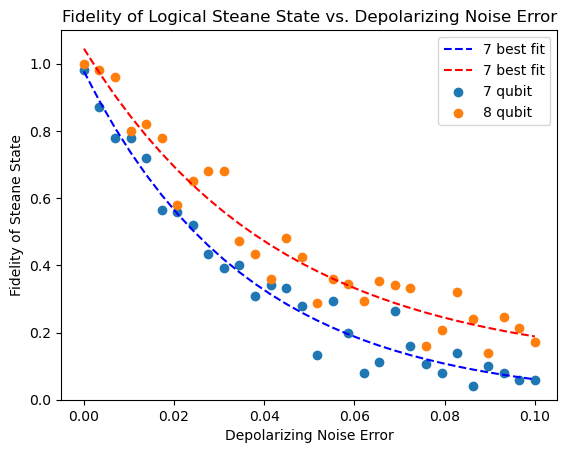

In [76]:
fid_theta_7_sv_df['mean'] = fid_theta_7_sv_df.mean(axis=1)
fid_theta_8_sv_df['mean'] = fid_theta_8_sv_df.mean(axis=1)

fid_model = Model(decay)
#print(f'independent variables: {decay_model.independent_vars}')


params = fid_model.make_params()

result_7 = fid_model.fit(fid_theta_7_sv_df['mean'], x=np.array(list(error_list)), a = 1, b = 0, r = 5)
result_8 = fid_model.fit(fid_theta_8_sv_df['mean'], x=np.array(list(error_list)), a = 1, b = 0, r = 5)

print(result_7.fit_report())
print(result_8.fit_report())

#plt.plot(error_list, result_7.init_fit, '--', label='initial fit')
plt.plot(error_list, result_7.best_fit, '--', label='7 best fit', color = "blue")
plt.plot(error_list, result_8.best_fit, '--', label='7 best fit', color = "red")


plt.scatter(x = error_list, y=fid_theta_7_sv_df['mean'], label="7 qubit")
plt.scatter(x = error_list, y=fid_theta_8_sv_df['mean'], label="8 qubit")
plt.title("Fidelity of Logical Steane State vs. Depolarizing Noise Error")
plt.xlabel("Depolarizing Noise Error")
plt.ylabel("Fidelity of Steane State")
plt.legend()

plt.ylim(0,1.1)

In [77]:
fid_theta_7_sv_df['mean']

physical error
0.000010    0.980000
0.003458    0.872361
0.006906    0.780000
0.010354    0.780000
0.013802    0.720000
0.017250    0.564721
0.020698    0.560000
0.024146    0.520000
0.027593    0.432361
0.031041    0.392361
0.034489    0.400000
0.037937    0.307639
0.041385    0.340000
0.044833    0.332361
0.048281    0.280000
0.051729    0.132361
0.055177    0.292361
0.058625    0.200000
0.062073    0.080000
0.065521    0.112361
0.068969    0.264721
0.072417    0.160000
0.075864    0.107639
0.079312    0.080000
0.082760    0.140000
0.086208    0.040000
0.089656    0.100000
0.093104    0.080000
0.096552    0.060000
0.100000    0.060000
Name: mean, dtype: float64

In [80]:
def get_sample_error_rate(fidelity_df: DataFrame, shots = 1000):
    sample_err_rate = []
    for fid in fidelity_df['mean']:
        print(fid)
        sample_err_rate.append((fid)*(1 - fid) / shots)
    
    return sample_err_rate
    



0.9800000000000005
0.8723606797749984
0.7800000000000006
0.7800000000000006
0.7200000000000005
0.5647213595499964
0.5600000000000005
0.5200000000000005
0.4323606797749984
0.39236067977499844
0.4000000000000005
0.3076393202250026
0.3400000000000006
0.33236067977499845
0.2800000000000004
0.13236067977499807
0.29236067977499836
0.20000000000000032
0.08000000000000011
0.11236067977499804
0.2647213595499962
0.16000000000000025
0.10763932022500225
0.08000000000000011
0.1400000000000002
0.040000000000000056
0.10000000000000014
0.08000000000000011
0.06000000000000008
0.06000000000000008
[0.019999999999999463, 0.12763932022500157, 0.21999999999999942, 0.21999999999999942, 0.27999999999999947, 0.43527864045000364, 0.4399999999999995, 0.47999999999999954, 0.5676393202250016, 0.6076393202250016, 0.5999999999999994, 0.6923606797749974, 0.6599999999999995, 0.6676393202250015, 0.7199999999999995, 0.8676393202250019, 0.7076393202250016, 0.7999999999999997, 0.9199999999999999, 0.8876393202250019, 0.735

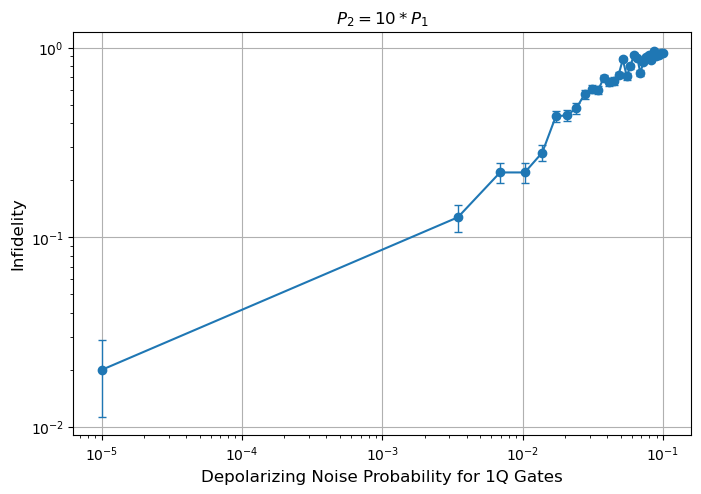

In [ ]:
# use plt error barrs
# use more shots 
#  about benchmarking logical gates for steane code
# error map for 1 and 2 qubit 
# have numbers for errors of each gate (H, CZ, meas)
# find way to measure effective logical error rate that isn't repeating QEC enc rounds



sample_err_rate_7 = get_sample_error_rate(fid_theta_7_sv_df)


fidelity_results_7 = fid_theta_7_sv_df['mean']


depol_probs = sorted(error_list)
fidelities_7 = [1 - fidelity_results_7.loc[p] for p in depol_probs]


print(fidelities_7)

# Uncertainty Calculations
unc_7 = [1.96 * np.sqrt(i) for i in sample_err_rate_7]



plt.figure(figsize=(7, 5))
plt.errorbar(
    depol_probs,
    fidelities_7,
    yerr=unc_7,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title("Infidelity vs Depolarizing noise probability")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

# P2 = 11*P 1Q err rates

In [ ]:
p2 = p*11
noise_model.add_all_qubit_quantum_error(depolarizing_error(p, 1), ['id', 's_hadamard'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cz']) 

In [105]:

err_list_size = 15
reps = 50
error_list = np.logspace((-4), (-2), err_list_size)
noise_list = []

for error in error_list:
    # readout_err = ReadoutError([[0.98, 0.02],  # P(measured 0 | actual 0), P(1 | 0)
    #                             [0.02, 0.98]]) # P(0 | 1), P(1 | 1)

    noise_model = NoiseModel()

    error2 = error*11

    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error2,2),['cz'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error2,2),['cx'])

    readout_err = ReadoutError([[1-error2, error2],  # P(measured 0 | actual 0), P(1 | 0)
                            [error2, 1-error2]]) # P(0 | 1), P(1 | 1)
    
    for i in range(0,7):
        noise_model.add_readout_error(readout_err, [i])

    
    noise_list.append(noise_model)

In [106]:


fid_theta_7_sv_df, fid_theta_8_sv_df = explore_error(reps, noise_list, err_list_size)

c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


1.0000000000000007
0.9800000000000006
0.9800000000000006
0.9323606797749985
0.9000000000000006
0.9800000000000006
0.9000000000000006
0.9123606797749985
0.7400000000000005
0.7247213595499964
0.7400000000000005
0.7447213595499965
0.42000000000000054
0.4800000000000005
0.25236067977499826


C:\Users\diyan\AppData\Local\Temp\ipykernel_15716\1872809574.py:18: RuntimeWarning: invalid value encountered in sqrt
  unc_7 = [1.96 * np.sqrt(i) for i in sample_err_rate_7]


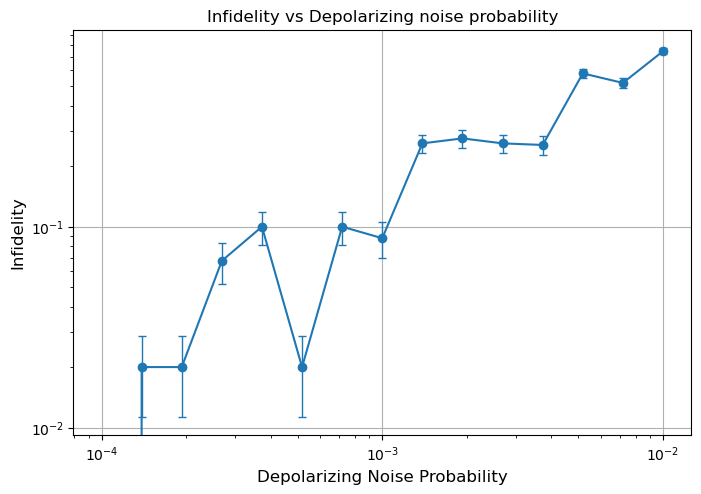

In [111]:
fid_theta_7_sv_df['mean'] = fid_theta_7_sv_df.mean(axis=1)
fid_theta_8_sv_df['mean'] = fid_theta_8_sv_df.mean(axis=1)


sample_err_rate_7 = get_sample_error_rate(fid_theta_7_sv_df)


fidelity_results_7 = fid_theta_7_sv_df['mean']


depol_probs = sorted(error_list)
fidelities_7 = [1 - fidelity_results_7.loc[p] for p in depol_probs]


#print(fidelities_7)

# Uncertainty Calculations
unc_7 = [1.96 * np.sqrt(i) for i in sample_err_rate_7]



plt.figure(figsize=(7, 5))
plt.errorbar(
    depol_probs,
    fidelities_7,
    yerr=unc_7,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title("Infidelity vs Depolarizing noise probability")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

In [108]:
from qiskit.quantum_info import Pauli
from qiskit_aer.noise import pauli_error 

In [109]:
pauli_probs = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2] 
noise_list = []
for p in pauli_probs:
    # New noise model for each depolarizing probability
    noise_model = NoiseModel()
    
    # Assign 1q and 2q Pauli errors
    noise_1q = [
        (Pauli('I'),    1-p), 
        (Pauli('X'),    2*p/5),
        (Pauli('Y'),    p/5),
        (Pauli('Z'),    2*p/5),
    ]
    
    two_qubit_paulis = []
    for P1 in ['I','X','Y','Z']:
        for P2 in ['I','X','Y','Z']:
            two_qubit_paulis.append((Pauli(P1+P2), None))

    p2 = 2*p
    noise_2q = []
    for pauli, _ in two_qubit_paulis:
        if pauli.to_label() == 'II':
            prob = 1 - p2
        else:
            prob = p2/15
        noise_2q.append((pauli, prob))
    
    

    # Apply depolarizing error with probability p
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_1q), ['id', 'h_targeted'])
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_2q), ['cz']) 

    # Keep readout error constant
    noise_model.add_readout_error(readout_err, [0])
    noise_model.add_readout_error(readout_err, [1])
    
    noise_list.append(noise_model)

In [110]:

fid_theta_7_sv_df, fid_theta_8_sv_df = explore_error(reps, noise_list, err_list_size)

c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


KeyError: '0x0'

In [ ]:

fidelity_results_7 = fid_theta_7_sv_df['mean']


depol_probs = sorted(error_list)
fidelities_7 = [1 - fidelity_results_7.loc[p] for p in depol_probs]

pauli_probs = sorted(fidelity_results.keys())
fidelities = [1 - fidelity_results[p] for p in pauli_probs]

plt.figure(figsize=(7, 5))
plt.plot(pauli_probs, fidelities, marker='o', linewidth=2)
plt.xlabel("Pauli Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title(f"$P_2 = 2 * P_1$")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

In [86]:
# num_meas = len(fid_theta_7_sv_df['mean'])
# sample_err_rate_7 = []
# for fid in fid_theta_7_sv_df['mean']:
#     print(fid)
#     sample_err_rate_7.append((fid)*(1 - fid) / num_meas)

# print(sample_err_rate_7)

shots = 1000
num_meas = len(fid_theta_8_sv_df['mean'])
sample_err_rate_8 = []
for fid in fid_theta_8_sv_df['mean']:
    print(fid)
    sample_err_rate_8.append((fid)*(1 - fid) / shots)

print(sample_err_rate_8)

1.0000000000000002
0.9800000000000001
0.9000000000000001
0.8400000000000002
0.792360679774998
0.8
0.6800000000000002
0.672360679774998
0.6276393202250022
0.572360679774998
0.612360679774998
0.672360679774998
0.412360679774998
0.4800000000000001
0.4076393202250022
0.4476393202250022
0.36000000000000004
0.36000000000000004
0.32000000000000006
0.36000000000000004
0.18000000000000008
0.3400000000000001
0.3076393202250022
0.19236067977499793
0.12472135954999583
0.2400000000000001
0.32472135954999587
0.22472135954999586
0.2847213595499959
0.12472135954999583
[-2.2204460492503136e-19, 1.959999999999991e-05, 8.99999999999999e-05, 0.00013439999999999988, 0.00016452523292150107, 0.00015999999999999999, 0.00021759999999999992, 0.00022029179606750058, 0.00023370820393249934, 0.0002447639320225002, 0.00023737507764050038, 0.00022029179606750058, 0.00024231934955049956, 0.0002496, 0.00024146950483150035, 0.00024725835921350013, 0.0002304, 0.0002304, 0.0002176, 0.0002304, 0.00014760000000000006, 0.00

[[Model]]
    Model(decay)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1411
    # data points      = 30
    # variables        = 3
    chi-square         = 1.5248e-04
    reduced chi-square = 5.6473e-06
    Akaike info crit   = -359.690807
    Bayesian info crit = -355.487215
    R-squared          = 0.17248102
[[Variables]]
    a:  155.845072 +/- 19166116.8 (12298185.94%) (init = 1)
    r:  2.2130e-04 +/- 27.4458769 (12402209.97%) (init = 5)
    b: -155.838254 +/- 19166116.8 (12298723.97%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -1.0000
    C(r, b) = +1.0000
    C(a, r) = -1.0000
[[Model]]
    Model(decay)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 784
    # data points      = 30
    # variables        = 3
    chi-square         = 1.2984e-04
    reduced chi-square = 4.8089e-06
    Akaike info crit   = -364.512276
    Bayesian info crit = -360.308684
    R-squared          = 0.072

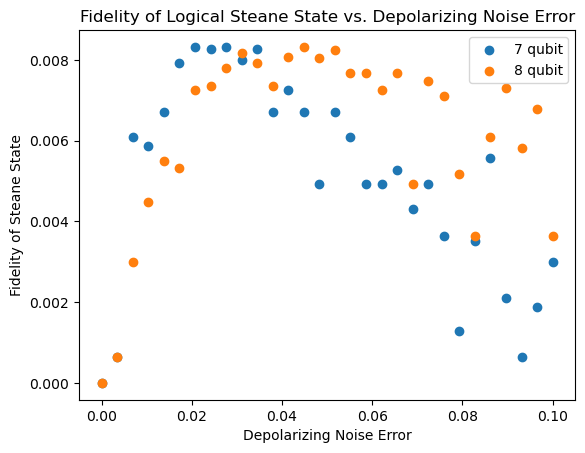

In [81]:
fid_model_2 = Model(decay)
#print(f'independent variables: {decay_model.independent_vars}')


params = fid_model_2.make_params()

result_r_7 = fid_model_2.fit(sample_err_rate_7, x=np.array(list(error_list)), a = 1, b = 0, r = 5)
result_r_8 = fid_model_2.fit(sample_err_rate_8, x=np.array(list(error_list)), a = 1, b = 0, r = 5)

print(result_r_7)

print(result_r_7.fit_report())
print(result_r_8.fit_report())

#plt.plot(error_list, result_7.init_fit, '--', label='initial fit')
# plt.plot(error_list, result_r_7.best_fit, '--', label='7 best fit', color = "blue")
# plt.plot(error_list, result_r_8.best_fit, '--', label='7 best fit', color = "red")


plt.scatter(x = error_list, y=sample_err_rate_7, label="7 qubit")
plt.scatter(x = error_list, y=sample_err_rate_8, label="8 qubit")
plt.title("Fidelity of Logical Steane State vs. Depolarizing Noise Error")
plt.xlabel("Depolarizing Noise Error")
plt.ylabel("Fidelity of Steane State")
plt.legend()

#plt.ylim(0,1.1)

In [232]:
fid_7_error_1 = fid_theta_7_sv_df.loc[error_list[0:5]]
fid_7_error_2 = fid_theta_7_sv_df.loc[error_list[5:10]]
fid_7_error_3 = fid_theta_7_sv_df.loc[error_list[10:15]]

fid_8_error_1 = fid_theta_8_sv_df.loc[error_list[0:5]]
fid_8_error_2 = fid_theta_8_sv_df.loc[error_list[5:10]]
fid_8_error_3 = fid_theta_8_sv_df.loc[error_list[10:15]]

In [251]:
fid_7_error_1

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
physical error,,,,,,,,,,,,,,,,,,,,,
0.001000,4.794037e-94,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.000000e+00,1.0,1.0,...,1.000000e+00,1.000000e+00,1.0,1.000000e+00,3.081488e-33,1.0,1.0,1.0,1.0,1.000000e+00
0.001179,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,3.544651e-35,1.0,1.0,...,1.000000e+00,1.000000e+00,1.0,2.041085e-32,1.000000e+00,1.0,1.0,1.0,1.0,4.794037e-94
0.001389,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,9.492775e-33,1.000000e+00,1.0,1.000000e+00,1.0,1.0,...,1.000000e+00,9.269025e-33,1.0,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.0,1.000000e+00
0.001638,1.000000e+00,0.618034,1.499760e-32,4.794037e-94,1.000000e+00,1.000000e+00,1.0,1.000000e+00,1.0,1.0,...,1.000000e+00,1.000000e+00,1.0,1.000000e+00,1.499760e-32,1.0,1.0,1.0,1.0,1.000000e+00
0.001931,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,9.495568e-66,1.0,1.645902e-96,1.0,1.0,...,4.794037e-94,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.0,1.000000e+00


In [276]:
fid_7_error_1[7]

physical error
0.001000    1.000000e+00
0.001179    3.544651e-35
0.001389    1.000000e+00
0.001638    1.000000e+00
0.001931    1.645902e-96
Name: 7, dtype: float64

In [ ]:
err_list_size = 50
reps = 10
error_list = np.logspace(-3,-2, err_list_size)
noise_list = []

for error in error_list:
    readout_err = ReadoutError([[0.98, 0.02],  # P(measured 0 | actual 0), P(1 | 0)
                                [0.02, 0.98]]) # P(0 | 1), P(1 | 1)

    noise_model = NoiseModel()

    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,2),['cz'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,2),['cx'])
    
    noise_list.append(noise_model)

In [ ]:

fid_theta_7_sv_df, fid_theta_8_sv_df = explore_error(reps, noise_list, err_list_size)

In [297]:
fid_theta_7_sv_df['mean'] = fid_theta_7_sv_df.mean(axis=1)
fid_theta_8_sv_df['mean'] = fid_theta_8_sv_df.mean(axis=1)

(0.0, 1.0)

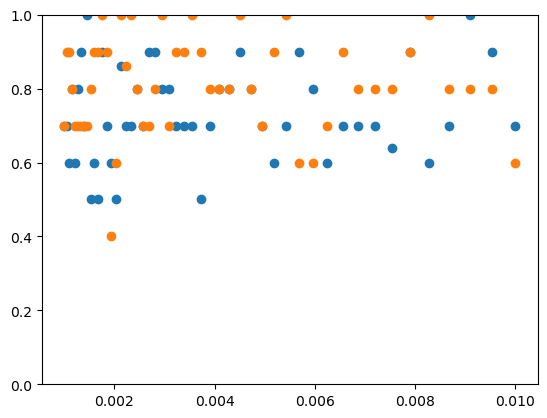

In [ ]:
fid_theta_7_sv_df['mean'] = fid_theta_7_sv_df.mean(axis=1)
fid_theta_8_sv_df['mean'] = fid_theta_8_sv_df.mean(axis=1)

plt.scatter(x = error_list, y=fid_theta_7_sv_df['mean'])
plt.scatter(x = error_list, y=fid_theta_8_sv_df['mean'])

plt.ylim(0,1)
# plt.xscale("log")
# plt.yscale("log")

In [284]:
def multi_error_plot(reps: int, fid_df: pd.DataFrame, error_list: list):
    # for i in range(0,reps):
    #     plt.bar(x = error_list, 
    #                 height = fid_df[i])
    
    plt.bar(x = error_list, height = fid_df)
    
    plt.show()


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (50,).

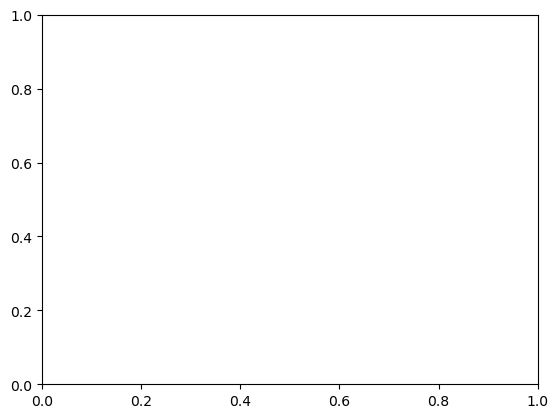

In [285]:
multi_error_plot(reps = 50, fid_df = fid_7_error_1, error_list = error_list[0:5])


multi_error_plot(reps = 50, fid_df = fid_theta_7_sv_df, error_list = error_list)

